In [1]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.stats import ttest_ind, ttest_1samp
import networkx as nx

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "figure4", "processed",
                                  "adata_processed_with_all_pseudotime_paths.h5ad")
                     )
adata.var.set_index("gene_name", inplace=True)

KO_genes = list(adata.obs["gene"].unique())
KO_genes.remove('non-targeting')  # Handled in a separate script

In [3]:
len(adata)

16835

## Model

In [4]:
batch_size = 16
n_latent = 0

In [5]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=0, use_2nd_order_interactions=False)

In [6]:
gene_names = mycellpop["gene"].name

In [7]:
obs_edges = mycellpop["gene", "regulates", "gene"].edges

## Load weights

In [8]:
all_conv_weights_dict = {}

for ko_gene in KO_genes:
    all_conv_weights_dict[ko_gene] = []
    for i in range(10):
        trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", 
                                                     "trained_mycellpop_feb_15_1_ko_" + ko_gene + 
                                                     "_seed_" + str(i) + ".pt"), 
                                        map_location=torch.device('cpu'))

        all_conv_weights_dict[ko_gene].append(trained_state_dict["simple_conv_weights"])
        
        
    all_conv_weights_dict[ko_gene] = torch.concat(all_conv_weights_dict[ko_gene])[:, :, 0]

In [9]:
# Observational data   
all_conv_weights_dict["obs"] = []
for i in range(10):
    trained_state_dict = torch.load(os.path.join(get_project_root(), "figure4", "logs", 
                                                 "trained_mycellpop_feb_22_1_seed_" + str(i) + ".pt"), 
                                    map_location=torch.device('cpu'))

    all_conv_weights_dict["obs"].append(trained_state_dict["simple_conv_weights"])


all_conv_weights_dict["obs"] = torch.concat(all_conv_weights_dict["obs"])[:, :, 0]

In [10]:
# All edges for each KO
kept_edge_dict = {}

for ko_gene in tqdm(KO_genes):
    ko_gene_idx = mycellpop["gene"].name.index(ko_gene)
    kept_edge_indices = (mycellpop['gene', 'regulates', 'gene'].edges[:, 0] != ko_gene_idx)
    kept_edge_dict[ko_gene] = kept_edge_indices

100%|██████████| 12/12 [00:00<00:00, 149.26it/s]


In [11]:
for k in KO_genes:
    ko_conv_weights_with_all_edges = torch.zeros(all_conv_weights_dict["obs"].shape)
    ko_conv_weights_with_all_edges[:, kept_edge_dict[k]] = all_conv_weights_dict[k]
    
    all_conv_weights_dict[k] = ko_conv_weights_with_all_edges


In [12]:
def get_edges_stats(all_conv_weights_dict, k):
    mean_ko = np.mean(all_conv_weights_dict[k].numpy(), axis=0)
    std_ko = np.std(all_conv_weights_dict[k].numpy(), axis=0)

    # Test when edge weight is siginificantly different from zero
    ttest_ko = ttest_1samp(all_conv_weights_dict[k].numpy(), 0)

    return mean_ko, std_ko, ttest_ko.statistic, ttest_ko.pvalue


In [13]:
def extract_most_affected_genes(df, key, ko_gene, target_len):
    # We exclude outgoing edges of the KO genes, for which hard constraints have been applied
    df = df[df["gene_1"].apply(lambda x: x != ko_gene)]

    n_top_edges = target_len // 2
    genes_most_affected = list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_1"]) + \
        list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_2"])
    
    while len(np.unique(genes_most_affected)) < target_len:
        n_top_edges += 1
        genes_most_affected = list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_1"]) + \
            list(df.sort_values(key, ascending=False).head(n_top_edges)["gene_2"])

    genes_most_affected = list(pd.DataFrame(genes_most_affected).value_counts().index)[:target_len]
    genes_most_affected = [g[0] for g in genes_most_affected]

    return genes_most_affected

In [14]:
mean_obs, std_obs, obs_tstatistic, obs_pvalue = get_edges_stats(all_conv_weights_dict, "obs")

most_affected_gene_dict = {}
all_edge_stats_dict = {}

for ko in tqdm(KO_genes):
    mean_ko, std_ko, ko_tstatistic, ko_pvalue = get_edges_stats(all_conv_weights_dict, ko)
    
    ko_vs_obs_mean_diff = np.abs(mean_ko - mean_obs)
    ko_vs_obs_uncertainty = np.sqrt((std_ko**2 + std_obs**2)/10)
    
    # Build DataFrame
    edge_stat_df_single_ko = pd.DataFrame(np.concatenate([ko_vs_obs_mean_diff[None], ko_vs_obs_uncertainty[None]]).T)
    edge_stat_df_single_ko.columns = ["ko_vs_obs_mean_diff", "ko_vs_obs_uncertainty"]
    edge_stat_df_single_ko["gene_1"] = [gene_names[i] for i in obs_edges.numpy()[:, 0]]
    edge_stat_df_single_ko["gene_2"] = [gene_names[i] for i in obs_edges.numpy()[:, 1]]

    most_affected_gene_dict[ko] = extract_most_affected_genes(edge_stat_df_single_ko, "ko_vs_obs_mean_diff", ko, 33)
    all_edge_stats_dict[ko] = edge_stat_df_single_ko

100%|██████████| 12/12 [07:23<00:00, 37.00s/it]


In [353]:
for ko_gene in most_affected_gene_dict:
    with open('genes_most_affected_edges_' + ko_gene + '_mean_diff.txt', 'w') as f:
        for gene in most_affected_gene_dict[ko_gene]:
            f.write(f"{gene}\n")

In [16]:
with open('all_genes.txt', 'w') as f:
    for gene in gene_names:
        f.write(f"{gene}\n")

In [60]:
import random 
random.seed(0)
rand_subsamp_genes = random.sample(gene_names, 33)

with open('rand_subsamp_genes.txt', 'w') as f:
    for gene in rand_subsamp_genes:
        f.write(f"{gene}\n")

## Plot affected subgraph

In [15]:
edge_to_idx_dict = {}

for i, e in enumerate(obs_edges.numpy().tolist()):
    edge_to_idx_dict[tuple(e)] = i

In [16]:
graph_edges = mycellpop["gene", "regulates", "gene"].edges.numpy().tolist()

In [17]:
g = nx.DiGraph()
g.add_nodes_from(range(4000))
g.add_edges_from(graph_edges)
nx.set_node_attributes(g, {i: mycellpop["gene"].name[i] for i in range(4000)}, name="name")

In [ ]:
def plot_most_affected_subgraph_for_ko(g, ko):

    sub_g = g.subgraph([i for i, n in enumerate(mycellpop["gene"].name) if n in most_affected_gene_dict[ko] or n == ko]).copy()

    sub_g_edges = list(sub_g.edges().keys())

    for e in sub_g_edges:

        edge_ko_weights = all_conv_weights_dict[ko][:, edge_to_idx_dict[(e[0], e[1])]]
        edge_obs_weights = all_conv_weights_dict['obs'][:, edge_to_idx_dict[(e[0], e[1])]]

        mean_ko = np.mean(edge_ko_weights.numpy())
        std_ko = np.std(edge_ko_weights.numpy())

        mean_obs = np.mean(edge_obs_weights.numpy())
        std_obs = np.std(edge_obs_weights.numpy())

        # Test when edge weight is siginificantly different from zero
        ttest_ko = ttest_1samp(edge_ko_weights.numpy(), 0)
        ttest_obs = ttest_1samp(edge_obs_weights.numpy(), 0)

        p_value_scaling = 10
        if ttest_ko.pvalue < p_value_scaling*(1/g.number_of_edges()) or \
            ttest_obs.pvalue < p_value_scaling*(1/g.number_of_edges()):

            sub_g.edges[e[0], e[1]]["mean_ko"] = mean_ko
            sub_g.edges[e[0], e[1]]["std_ko"] = std_ko

            sub_g.edges[e[0], e[1]]["mean_obs"] = mean_obs
            sub_g.edges[e[0], e[1]]["std_obs"] = std_obs
        else:
            # if the edge is not significantly different from zero, we remove it
            sub_g.remove_edge(e[0], e[1])

    sub_g = sub_g.subgraph(max(nx.connected_components(sub_g.to_undirected()), key=len)).copy()

    nx.write_gexf(sub_g, "processed/sub_g_" + ko +".gexf")

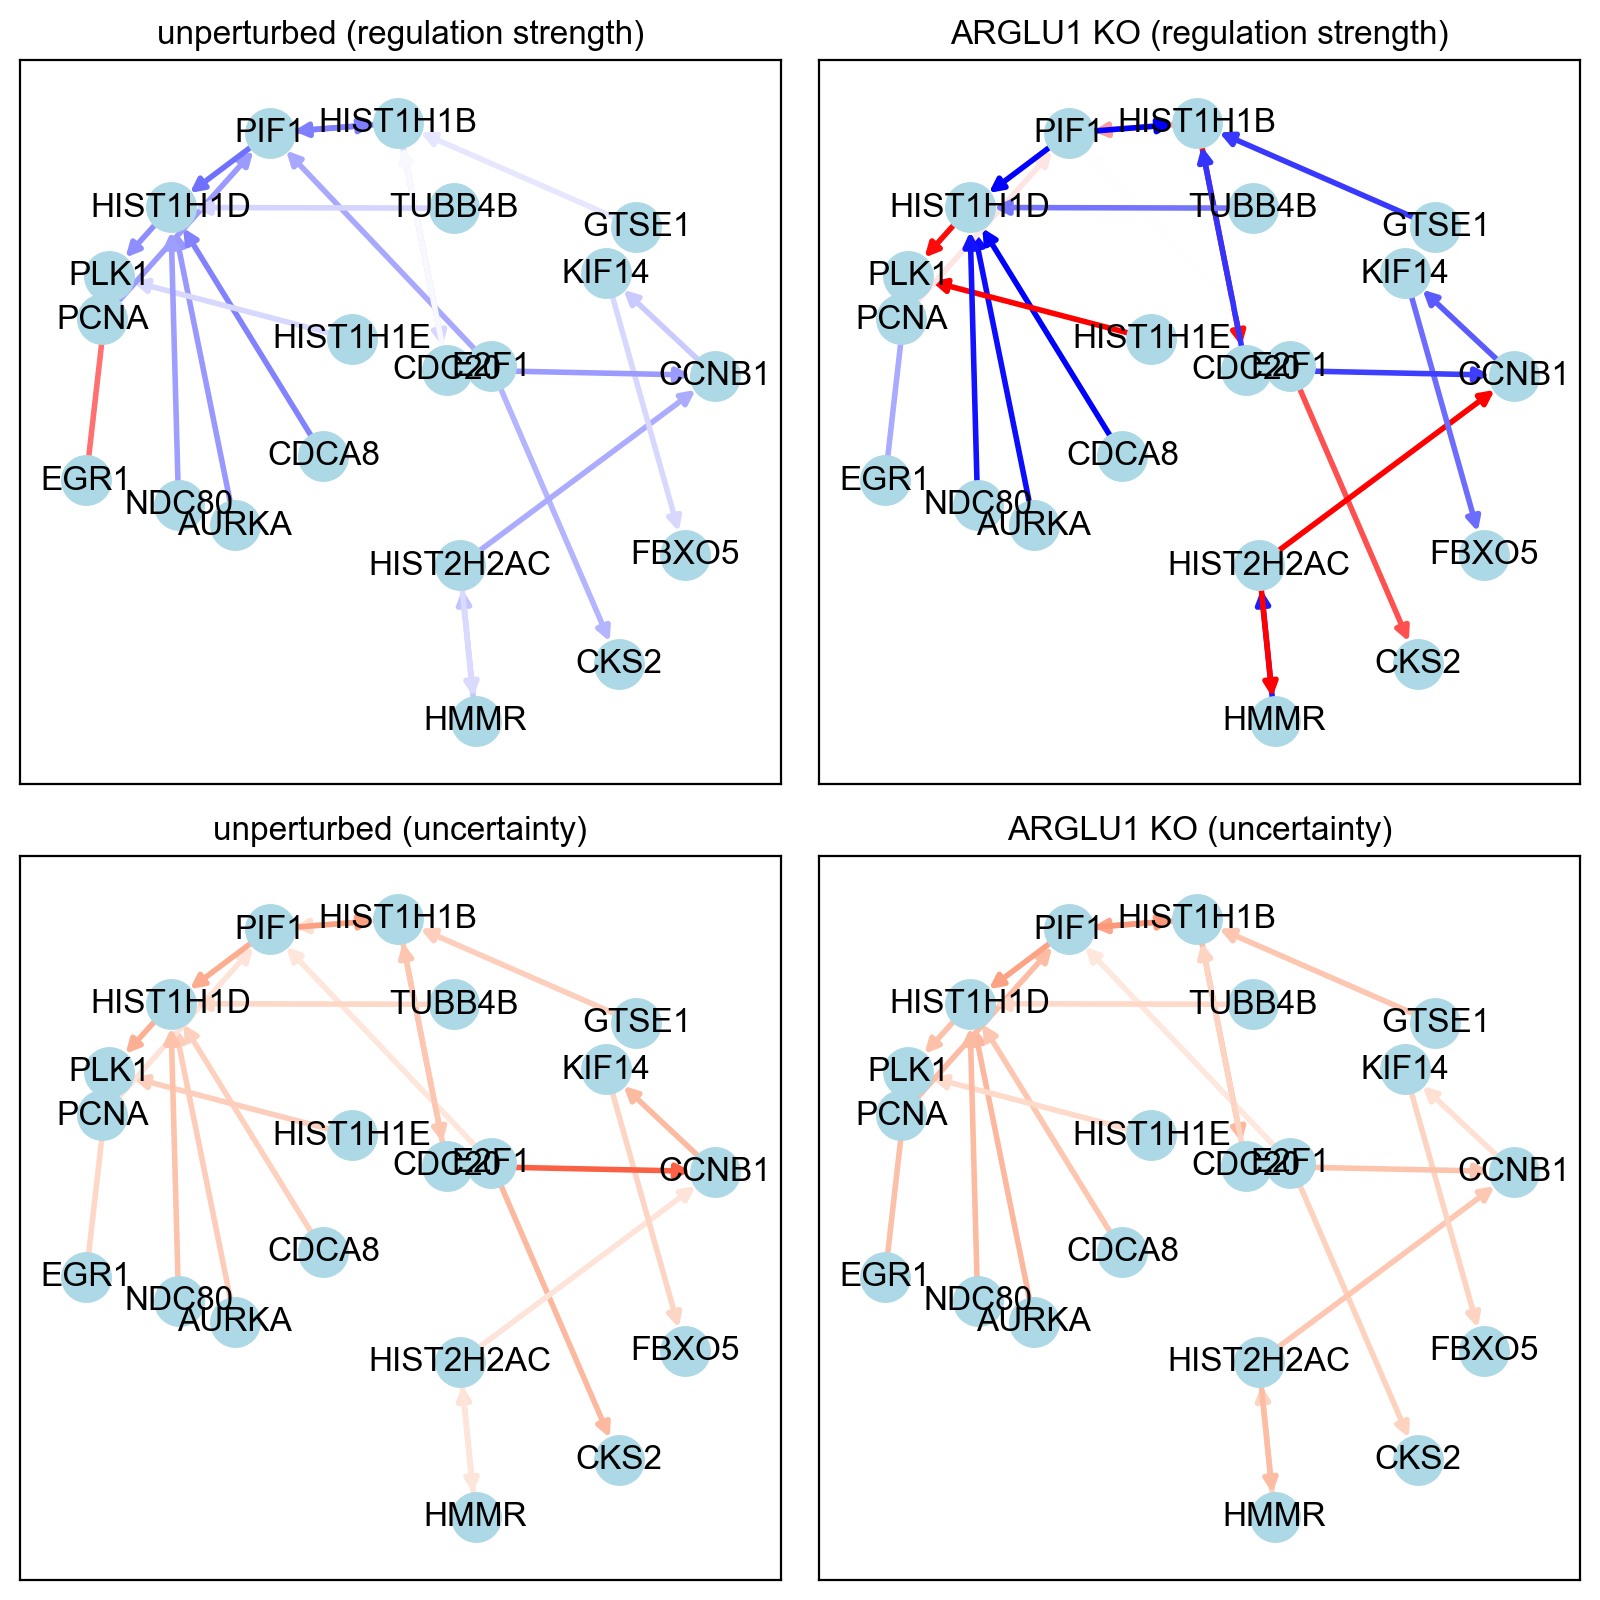

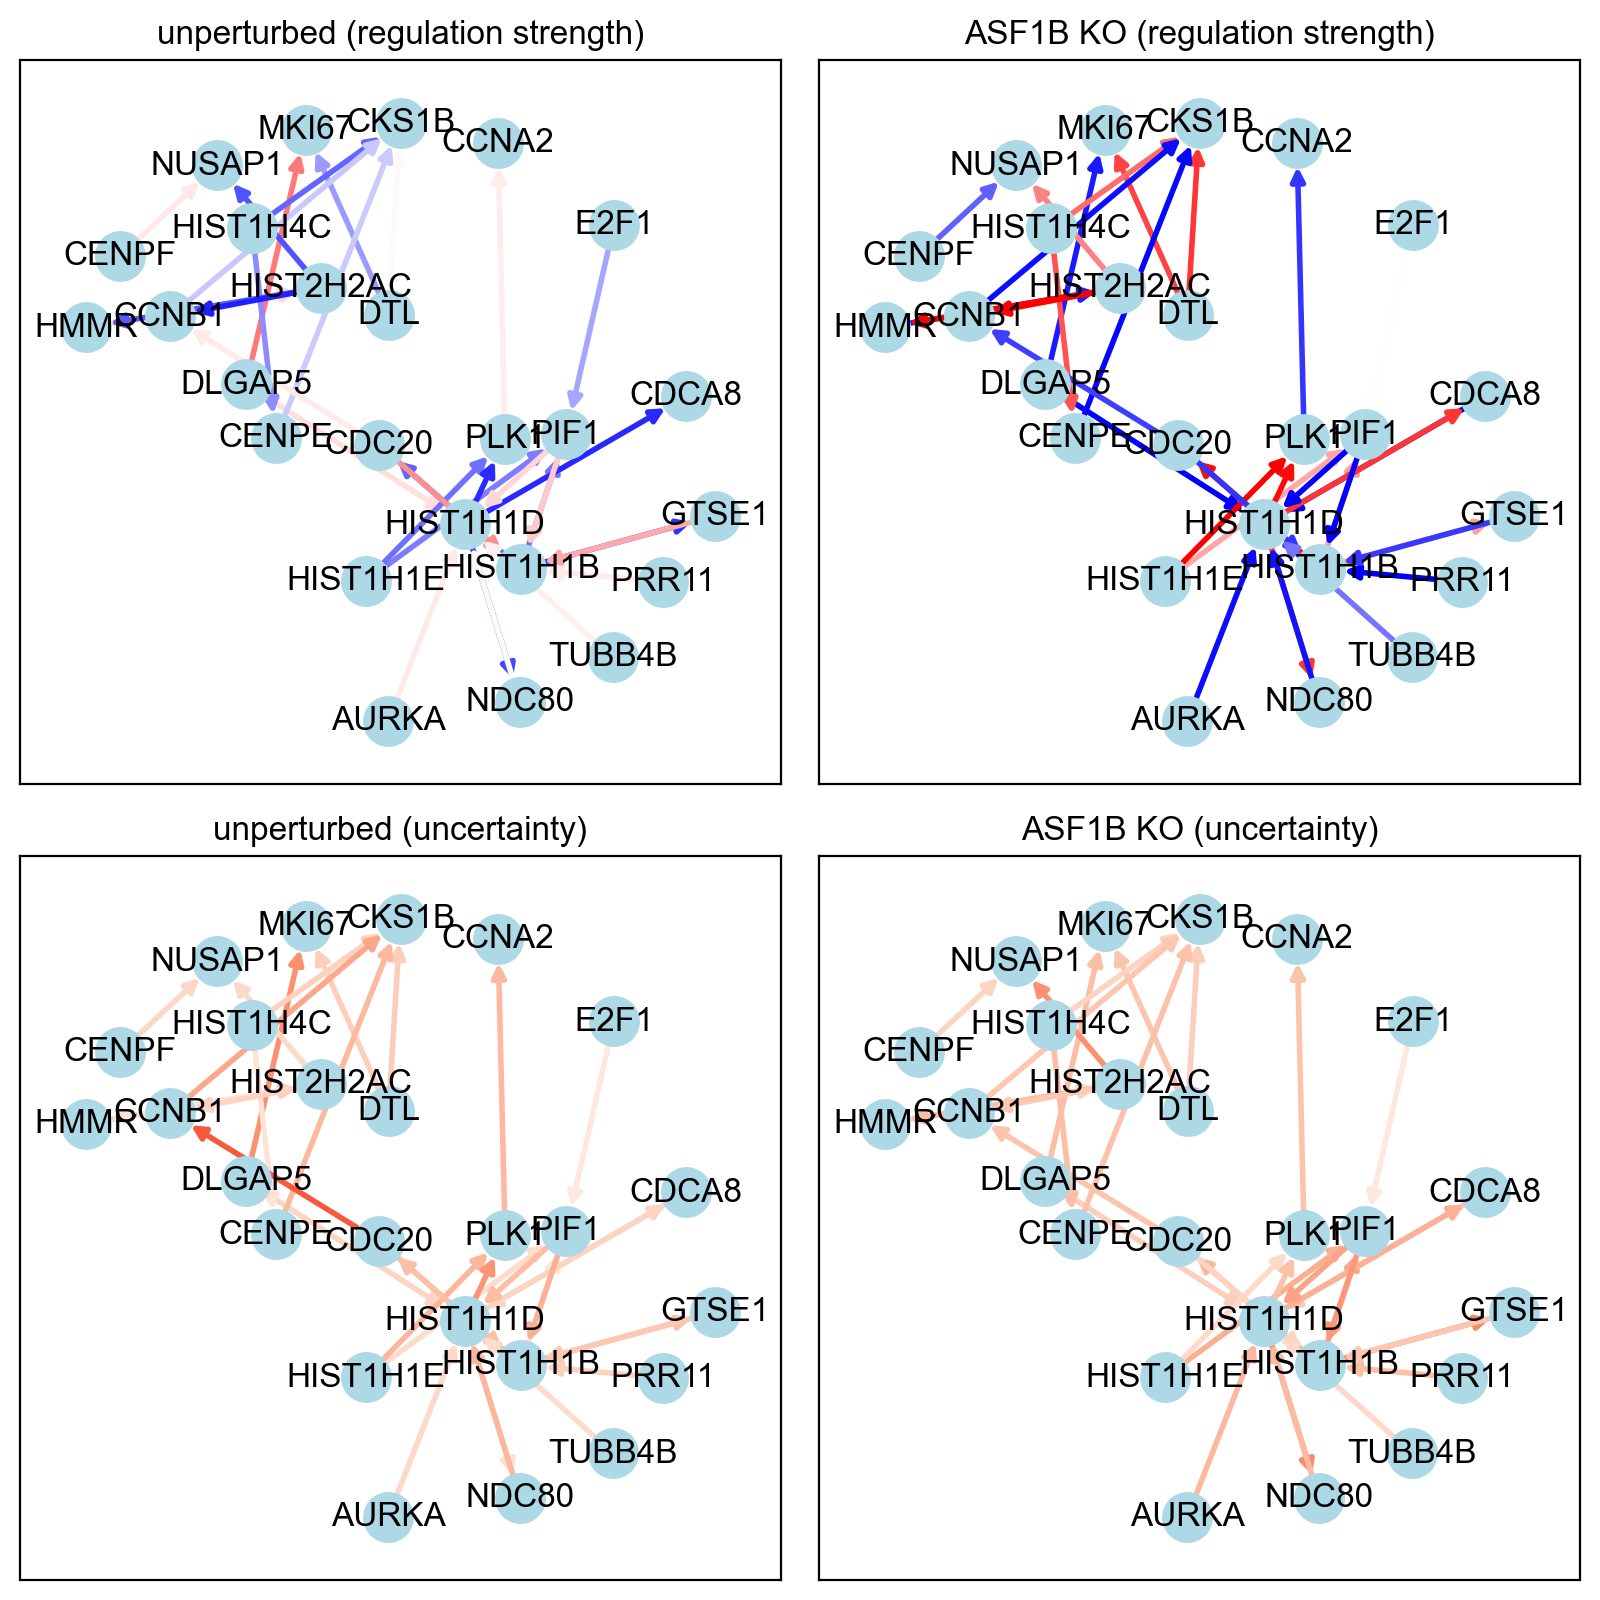

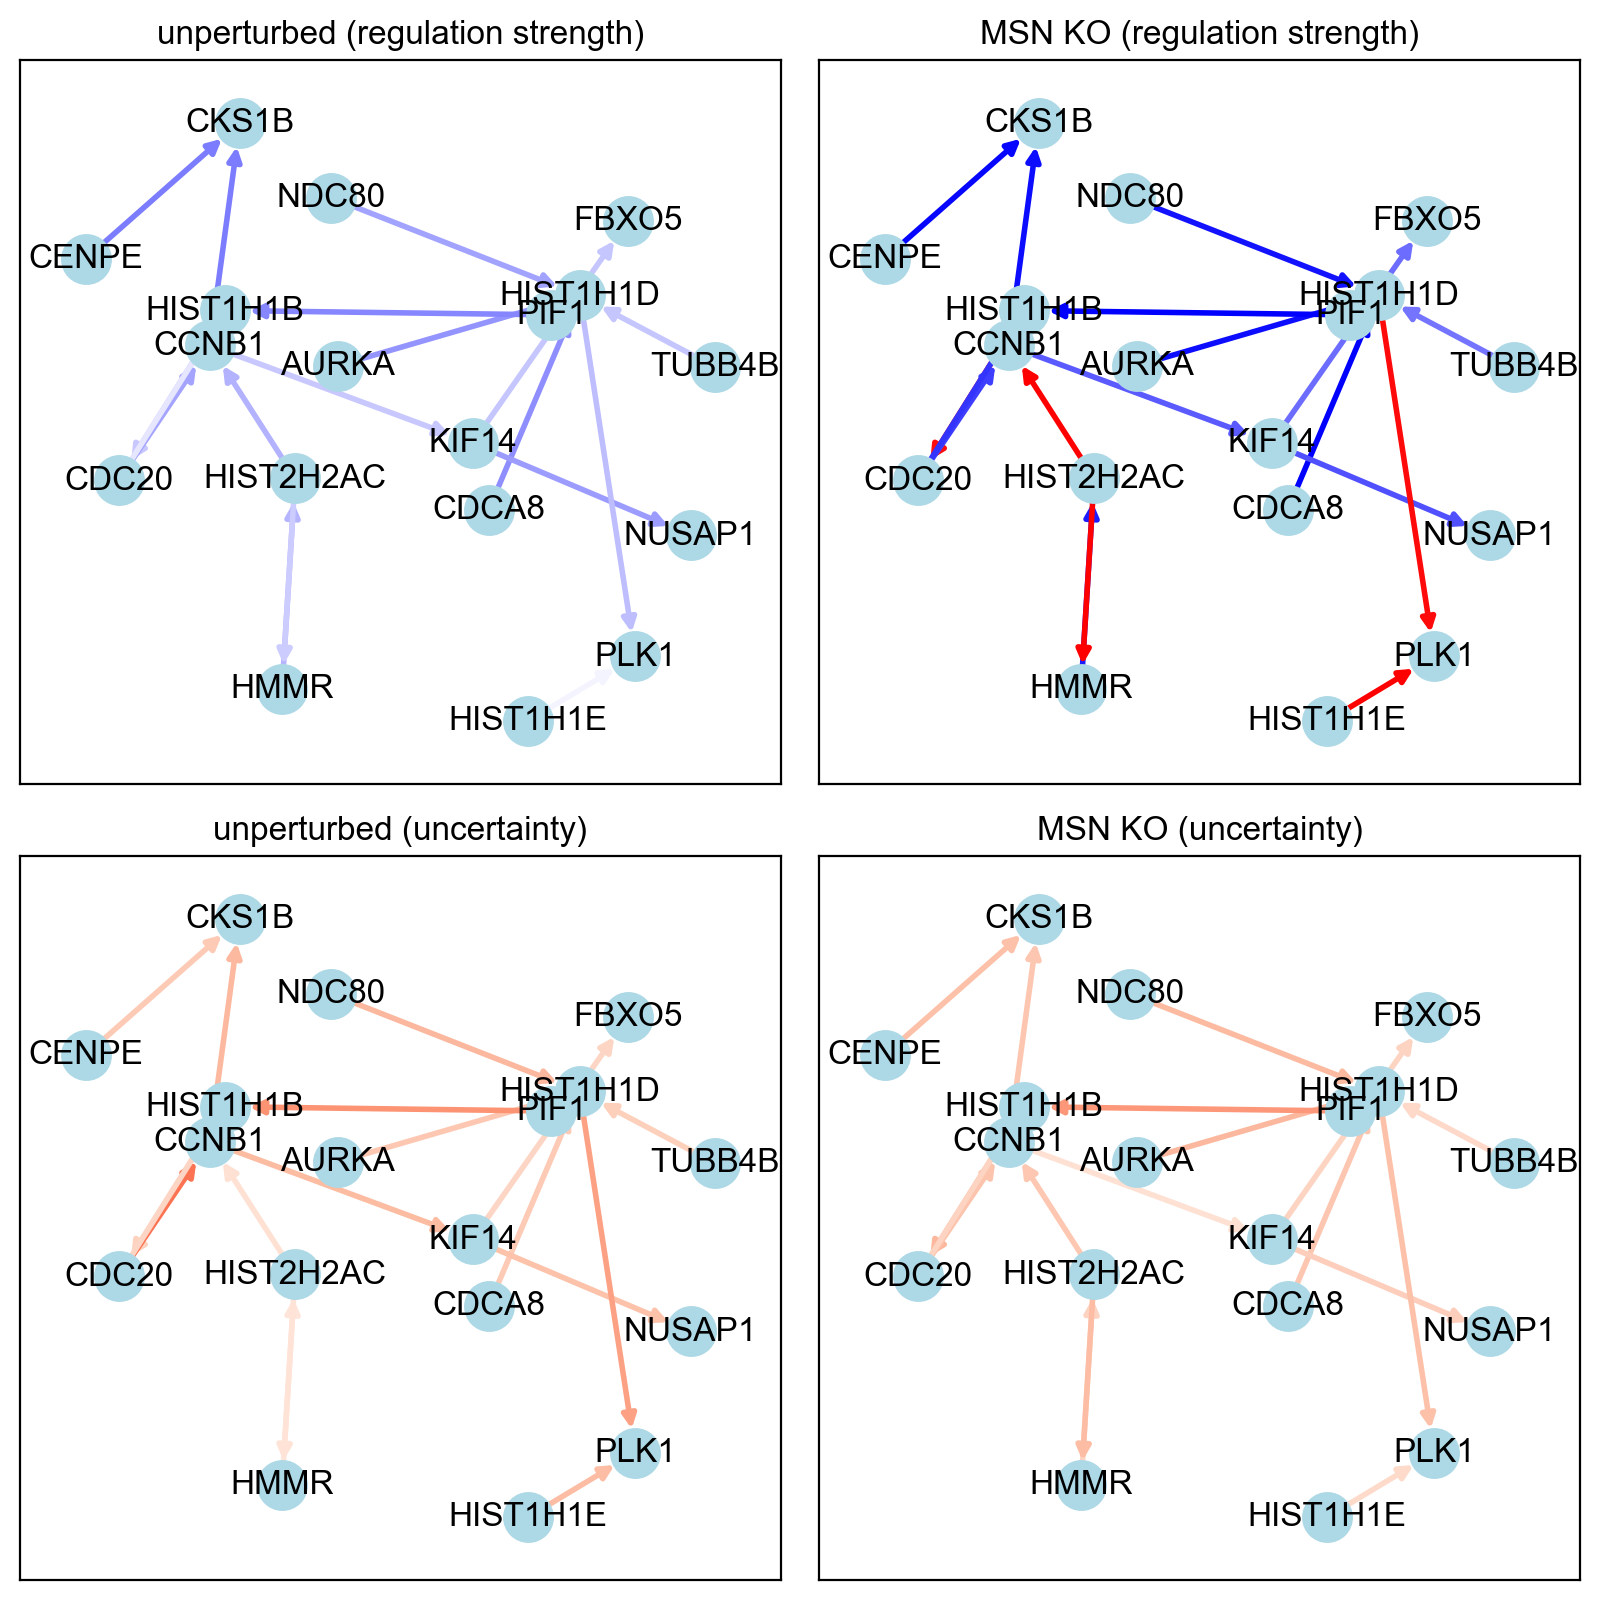

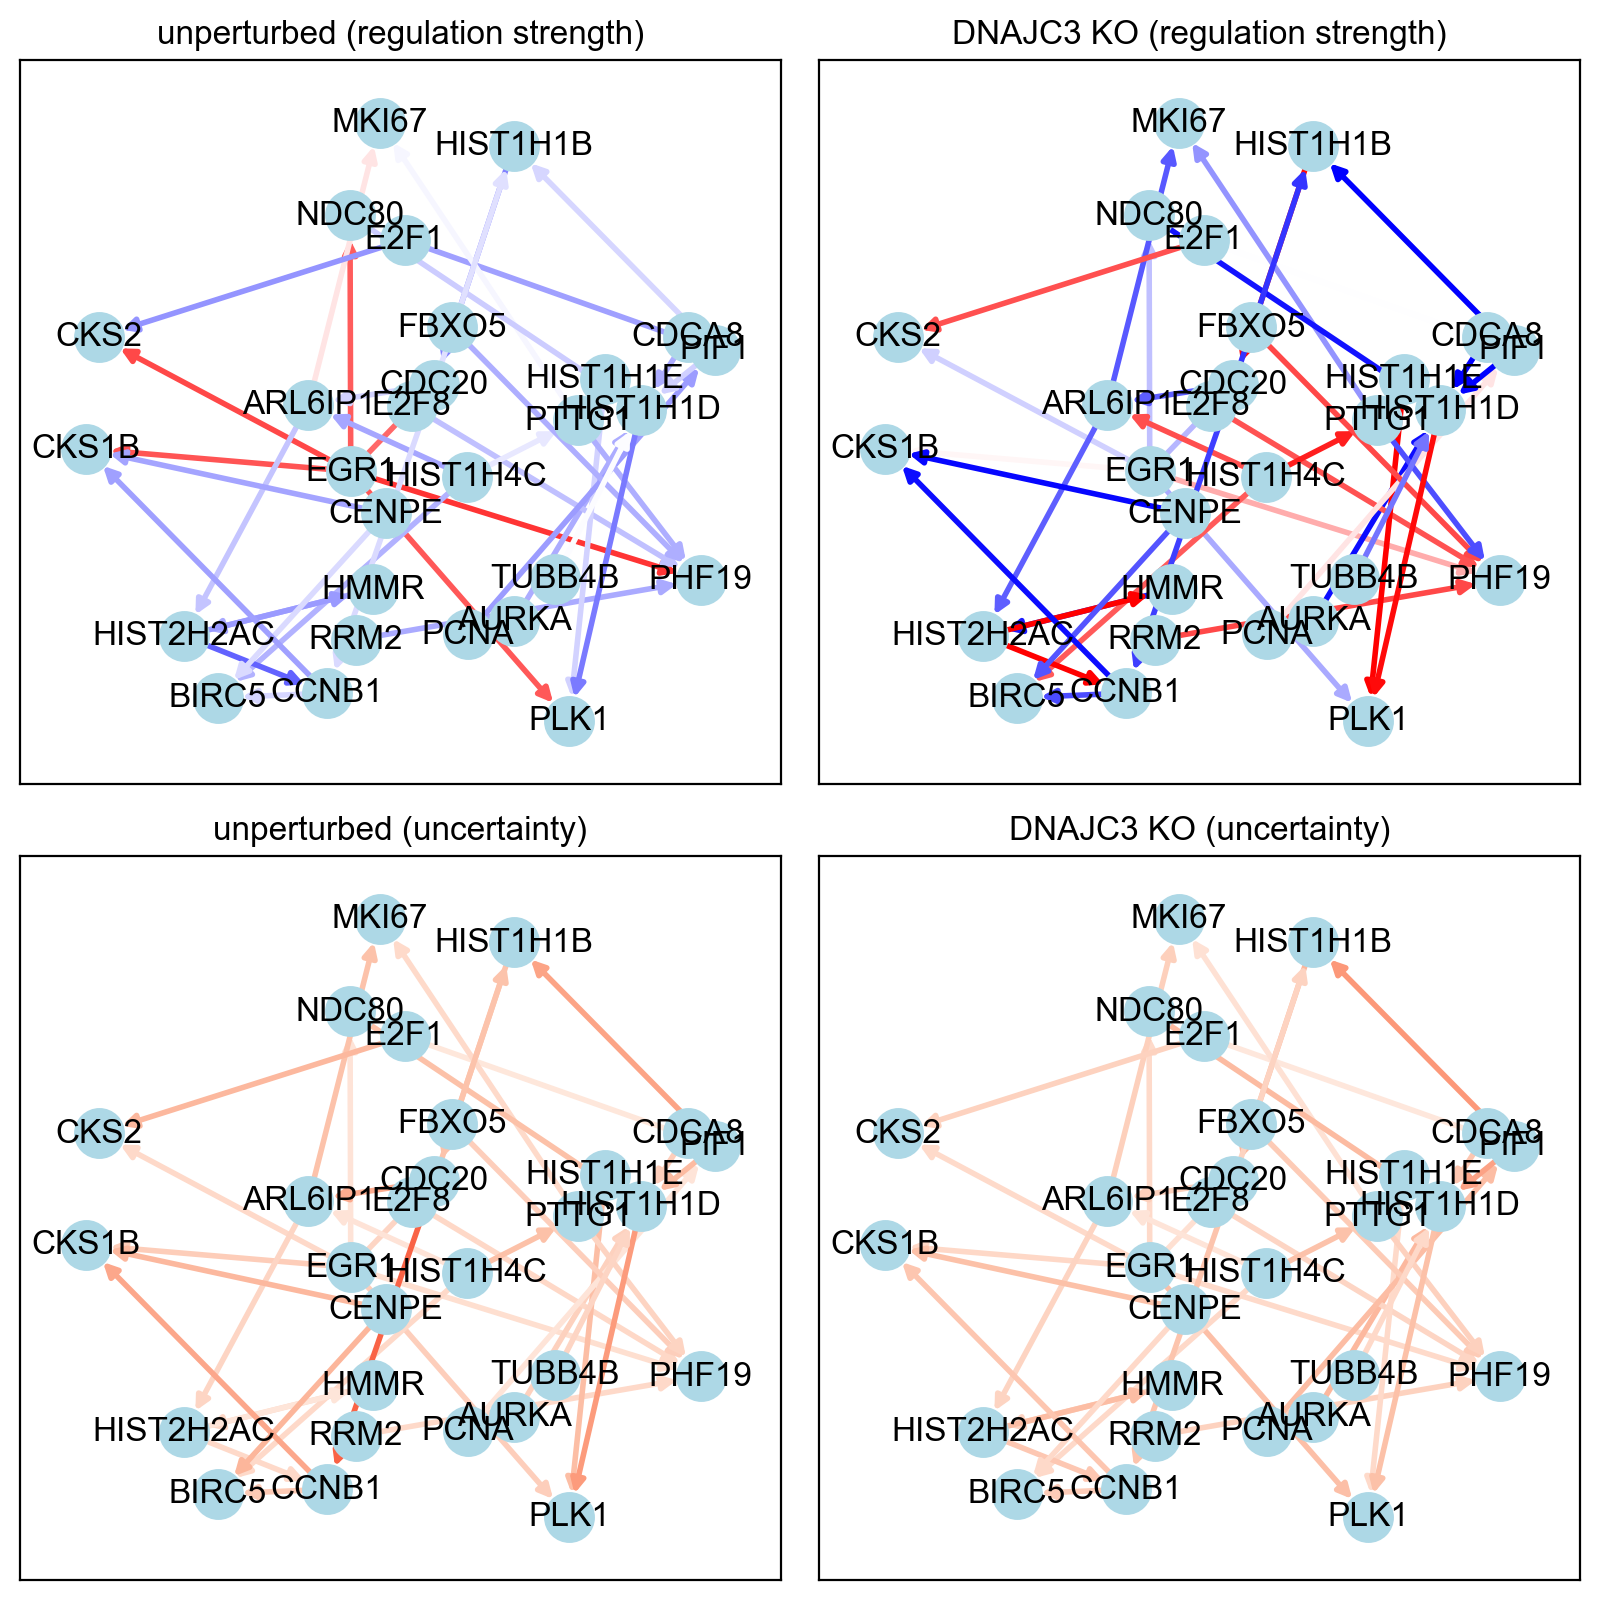

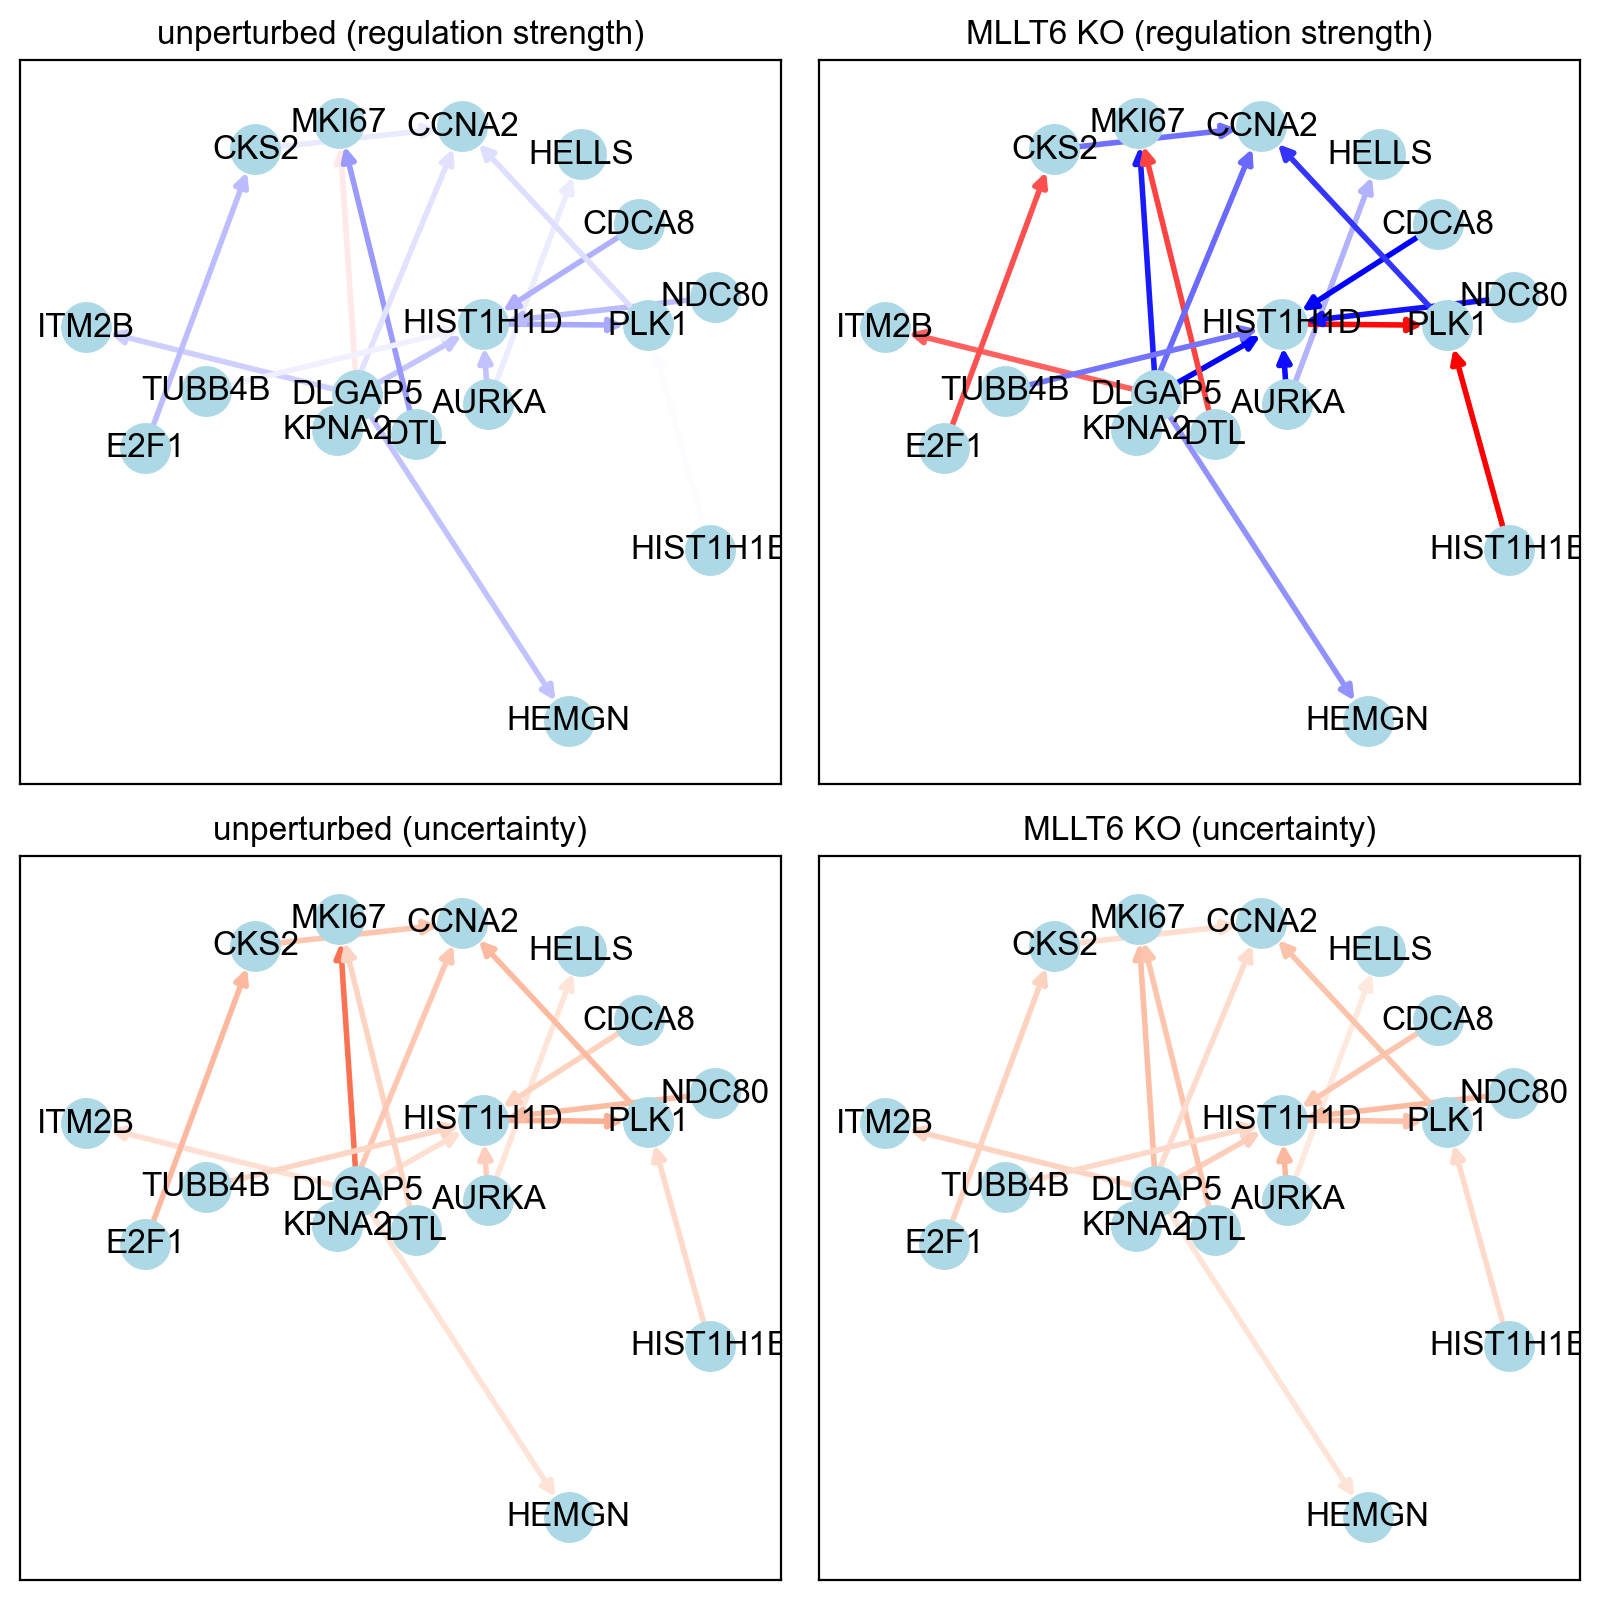

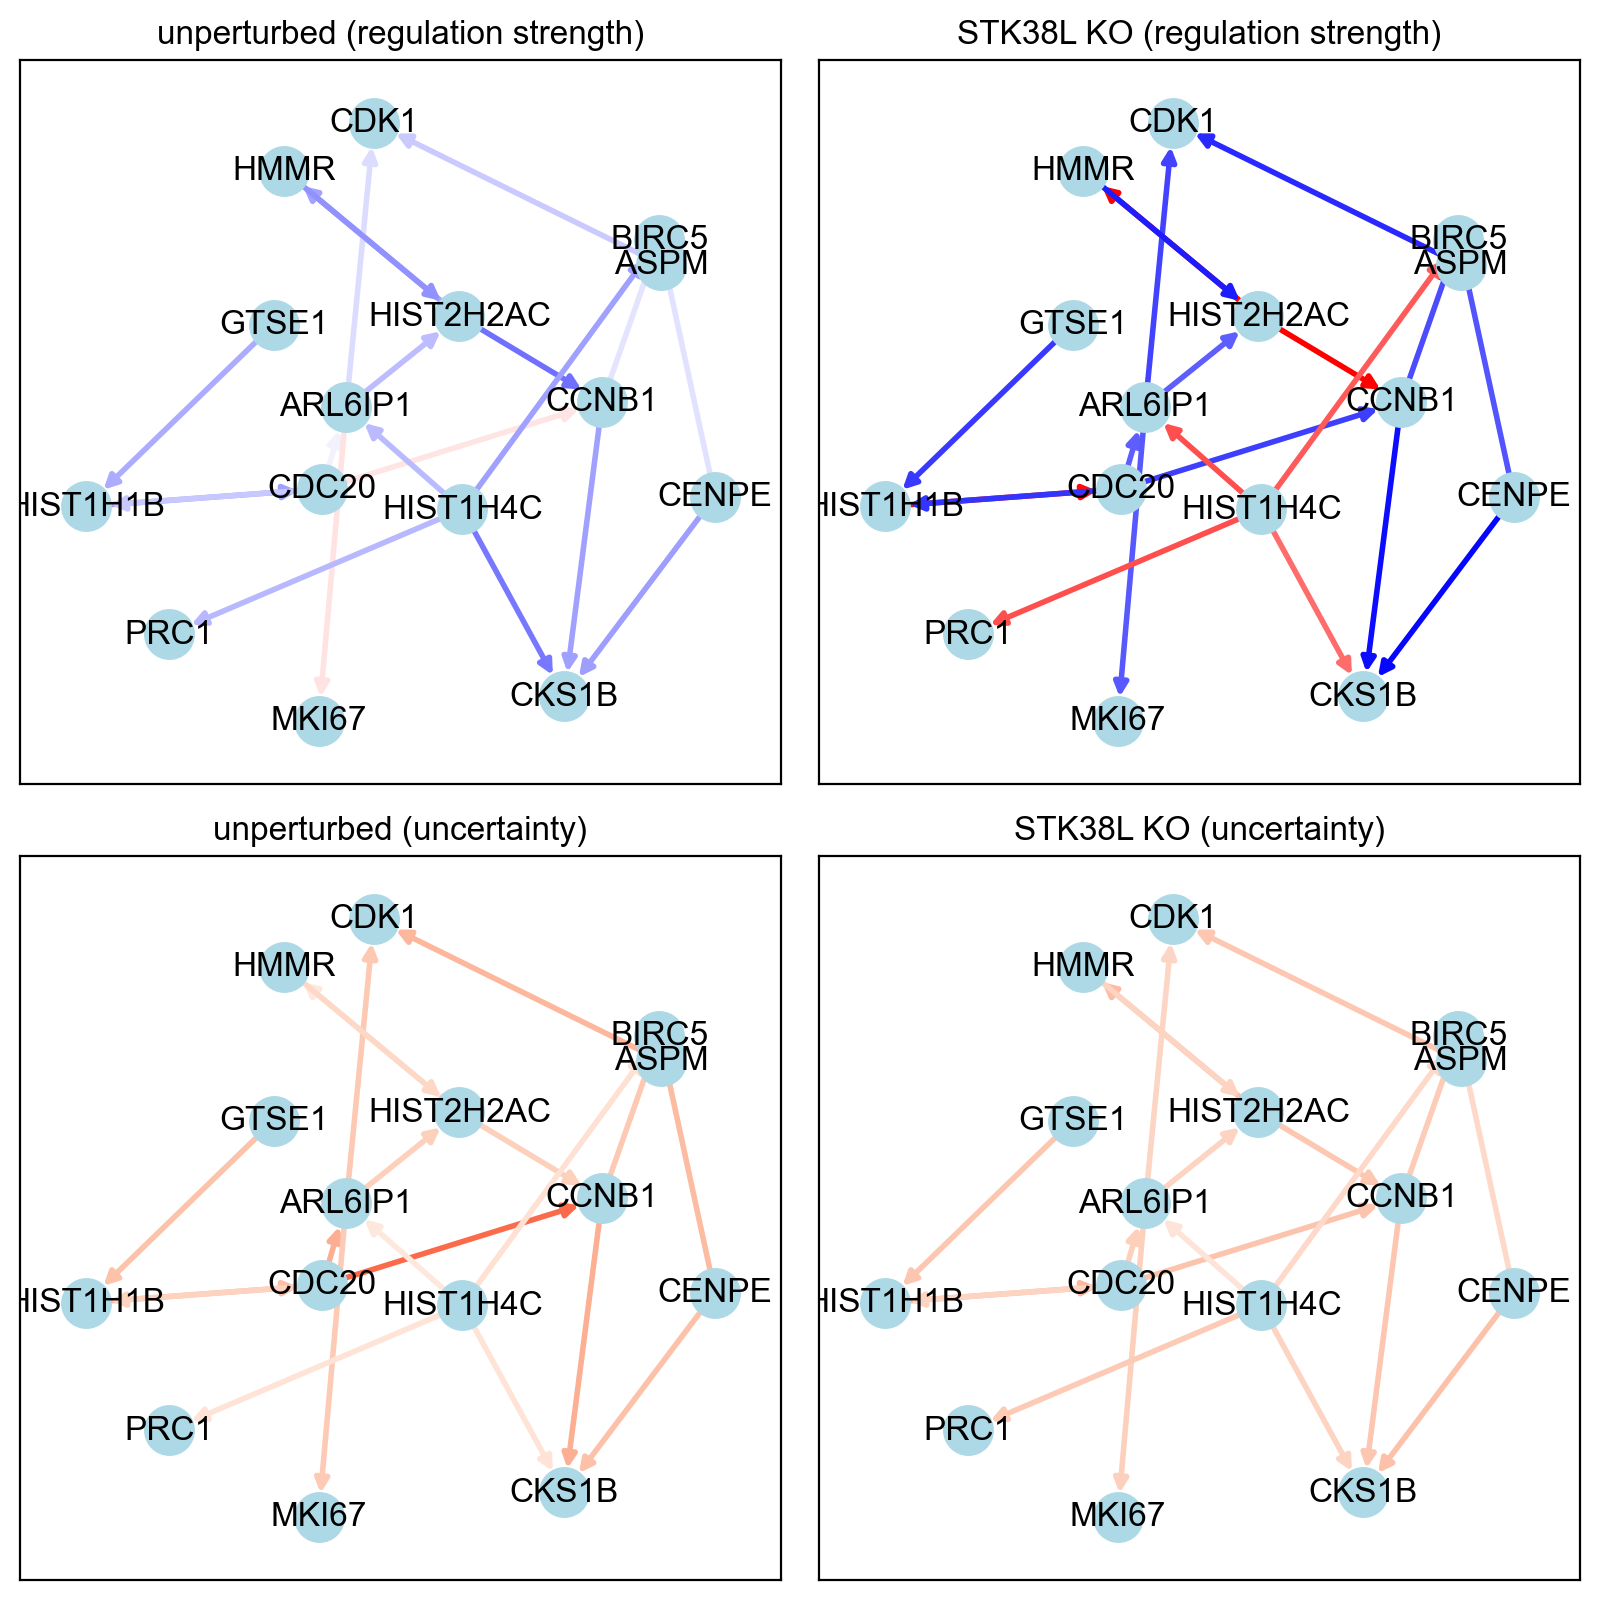

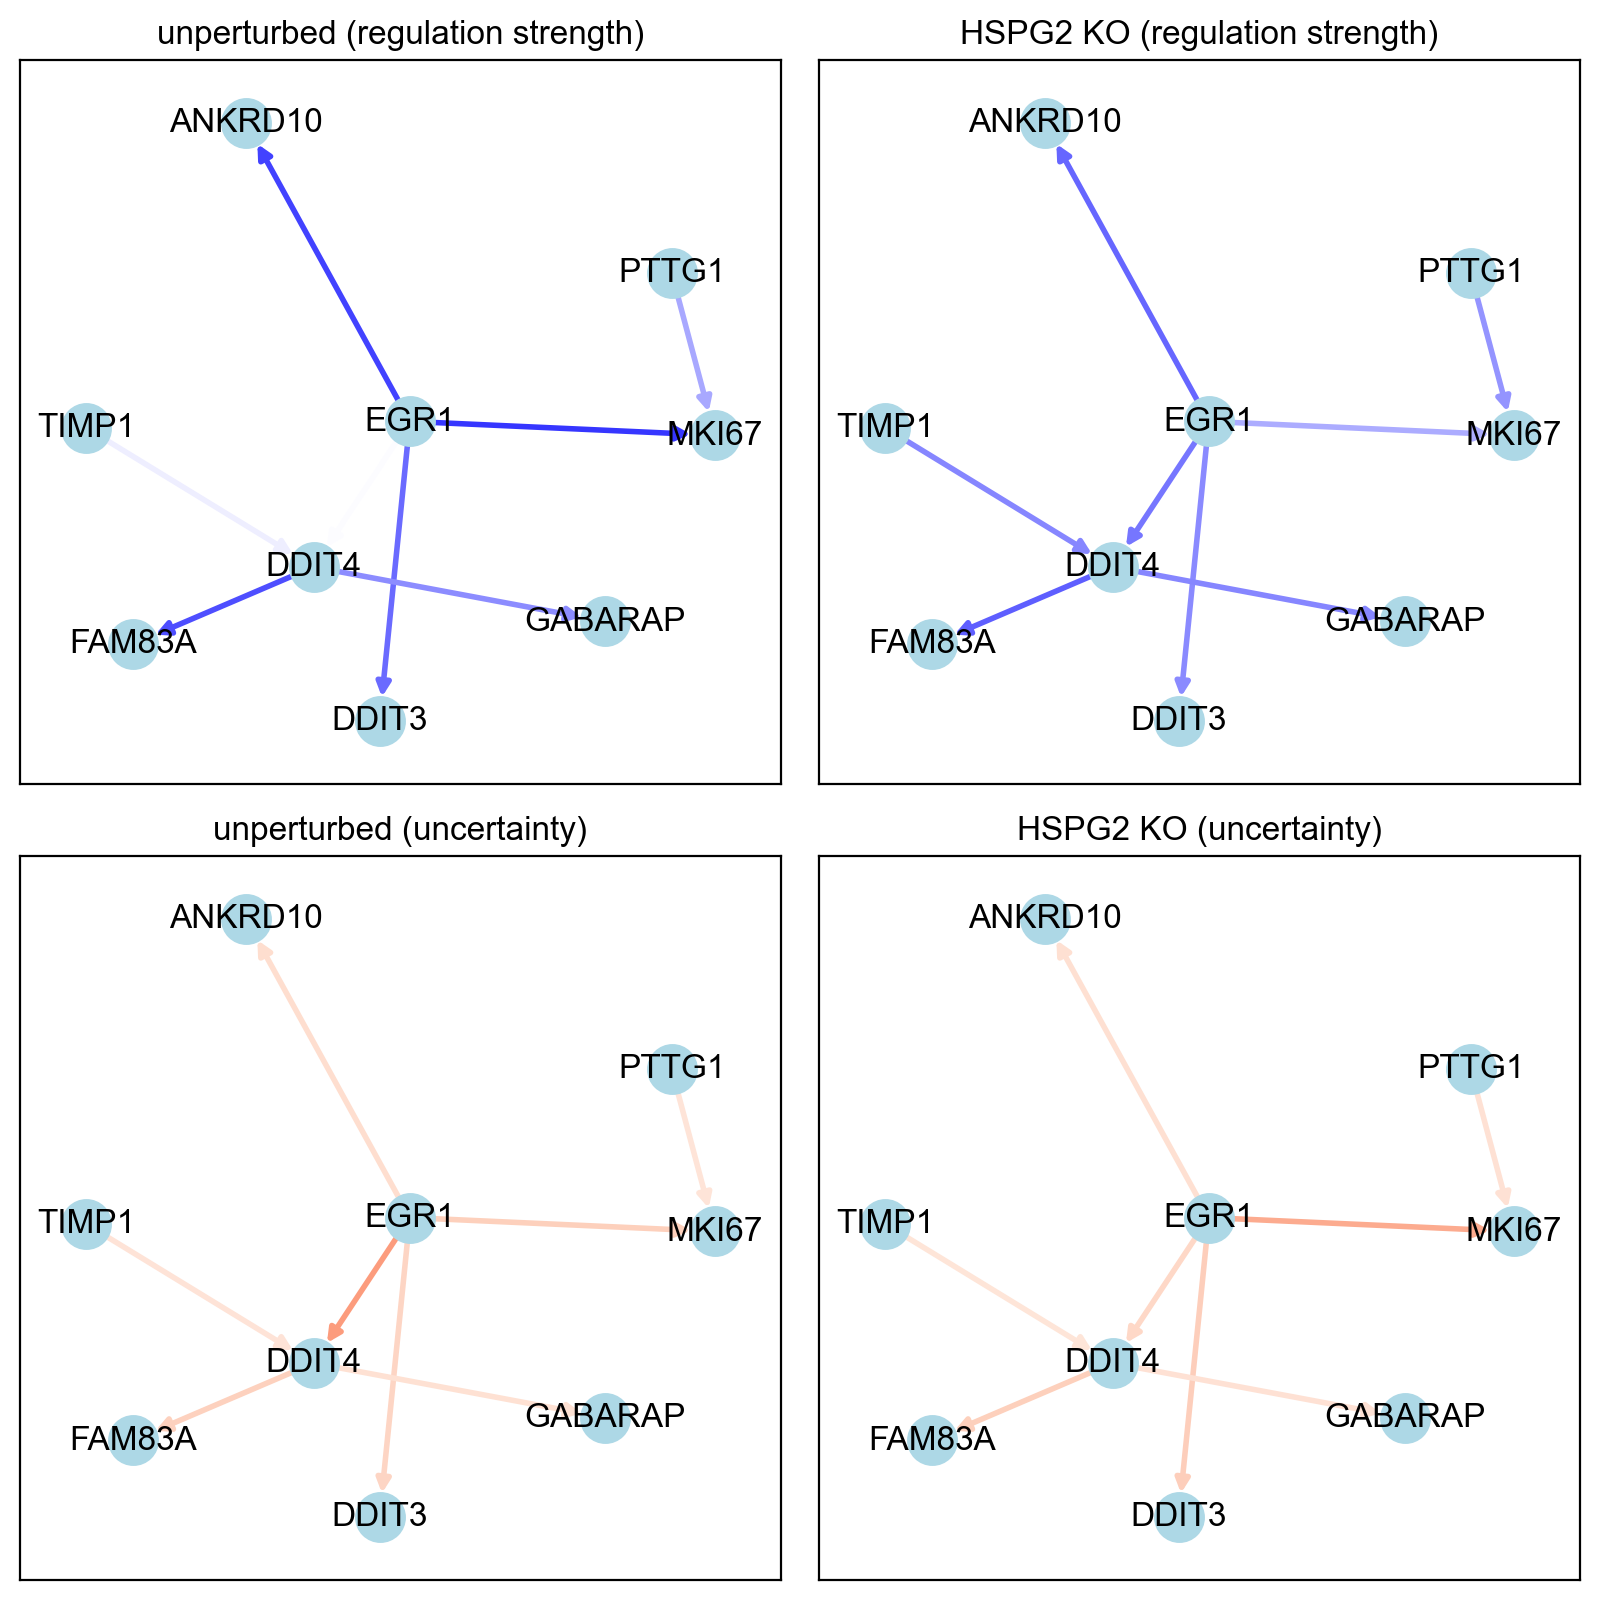

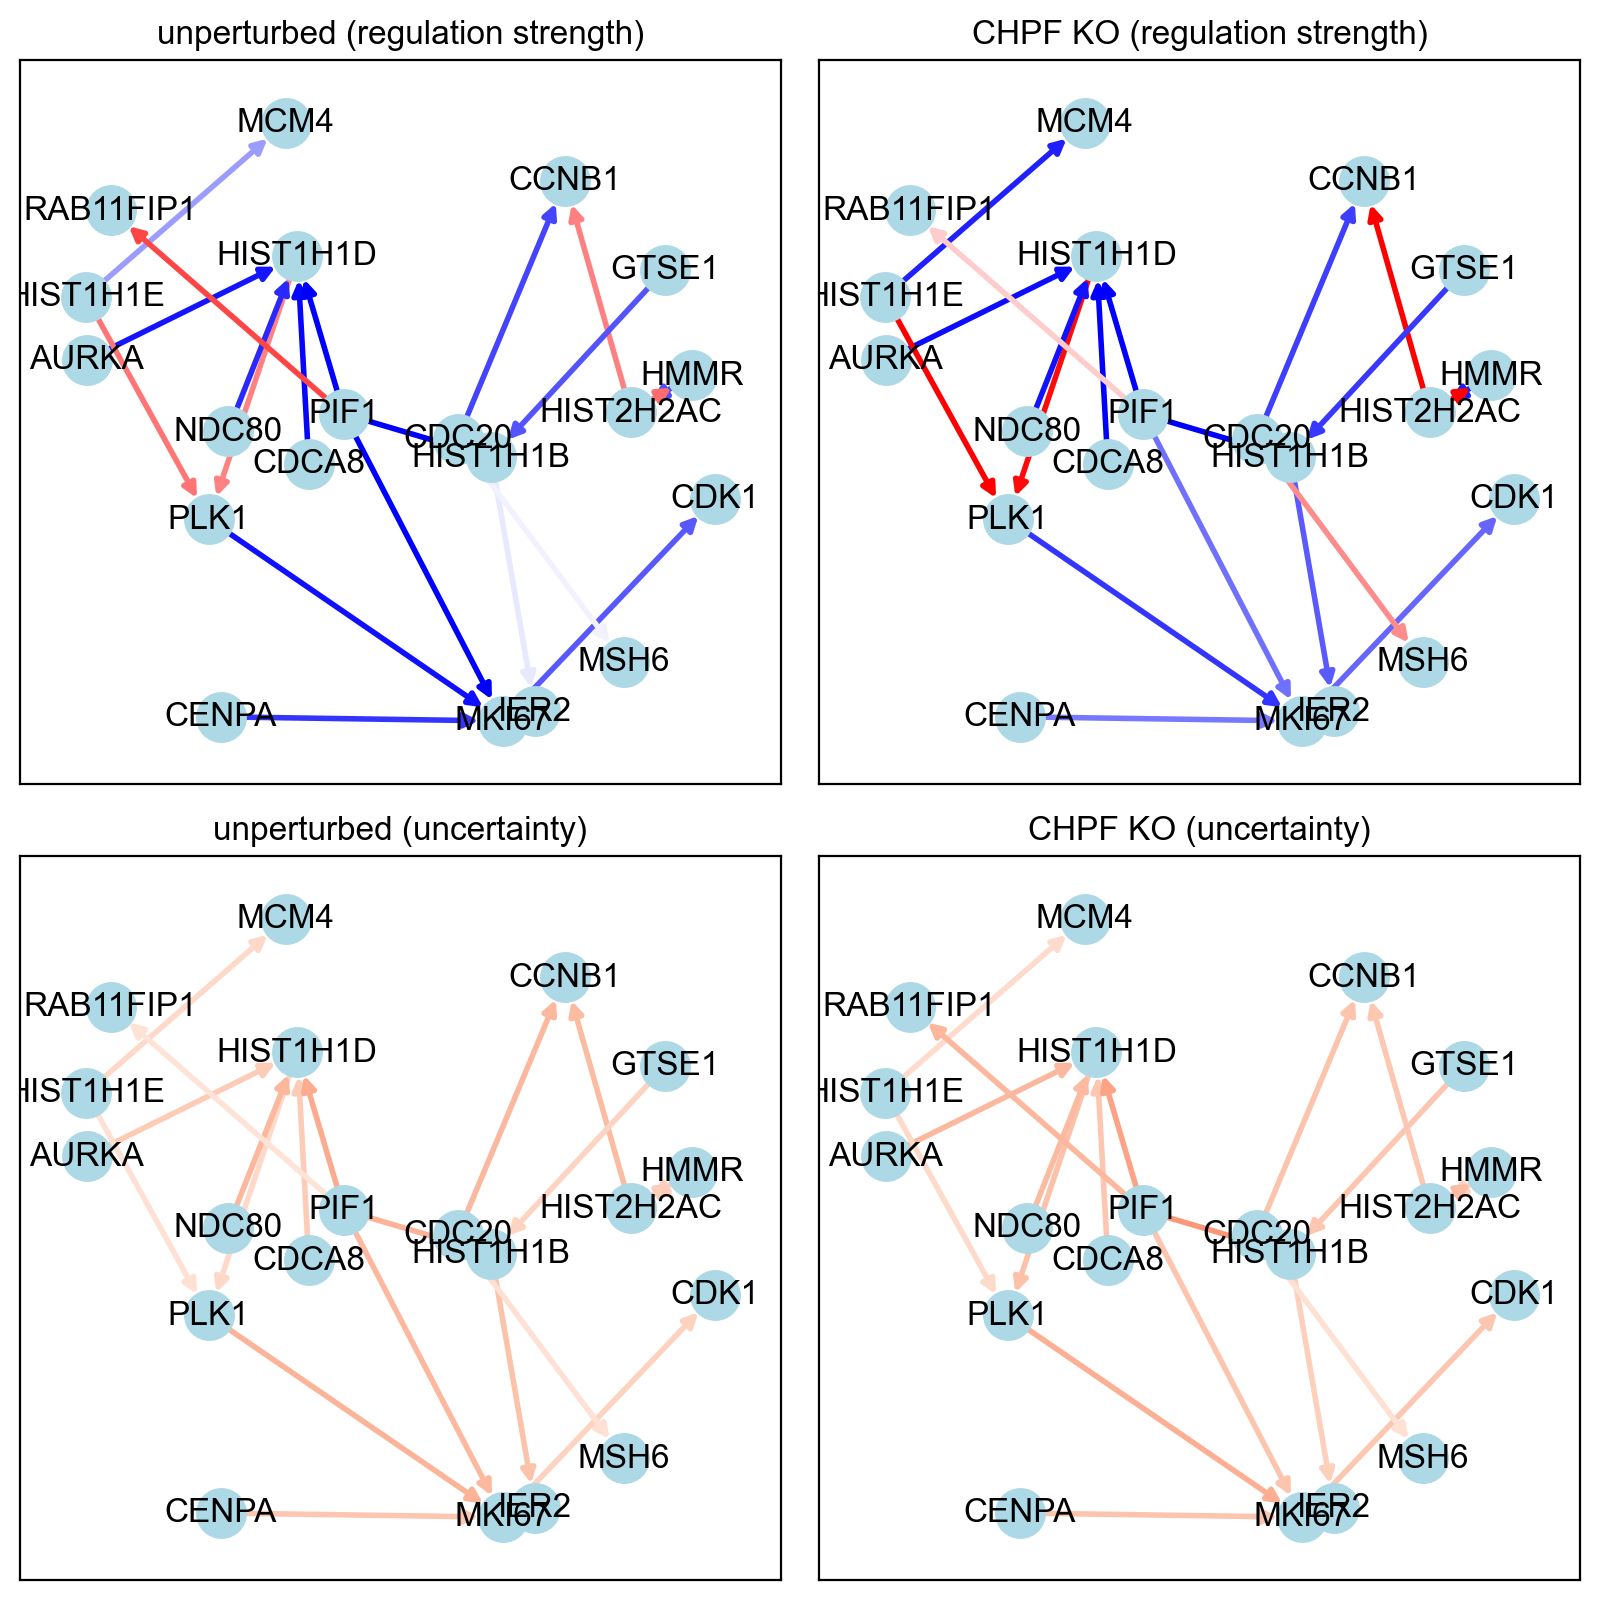

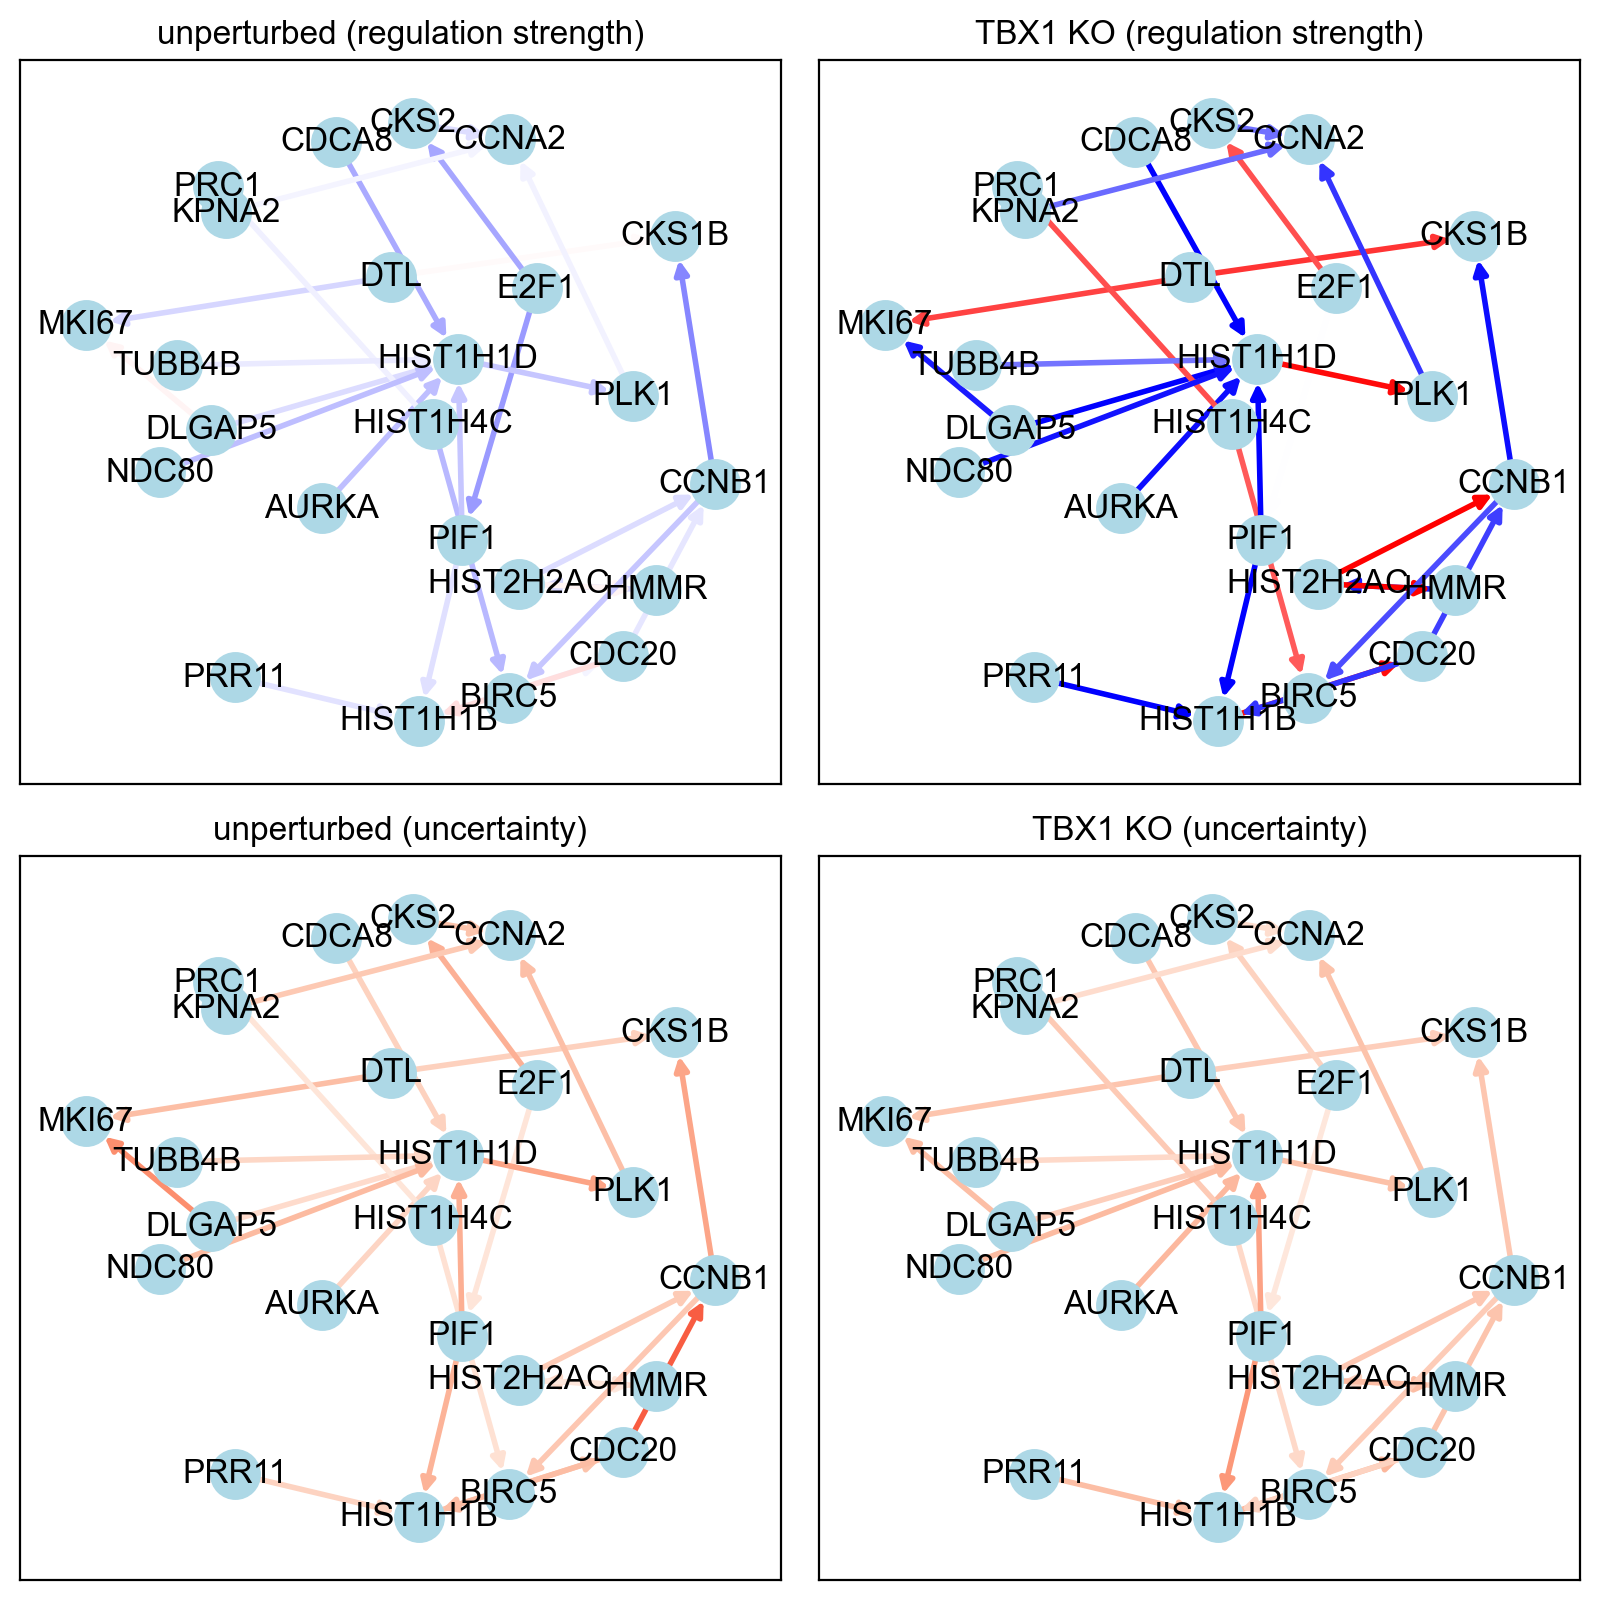

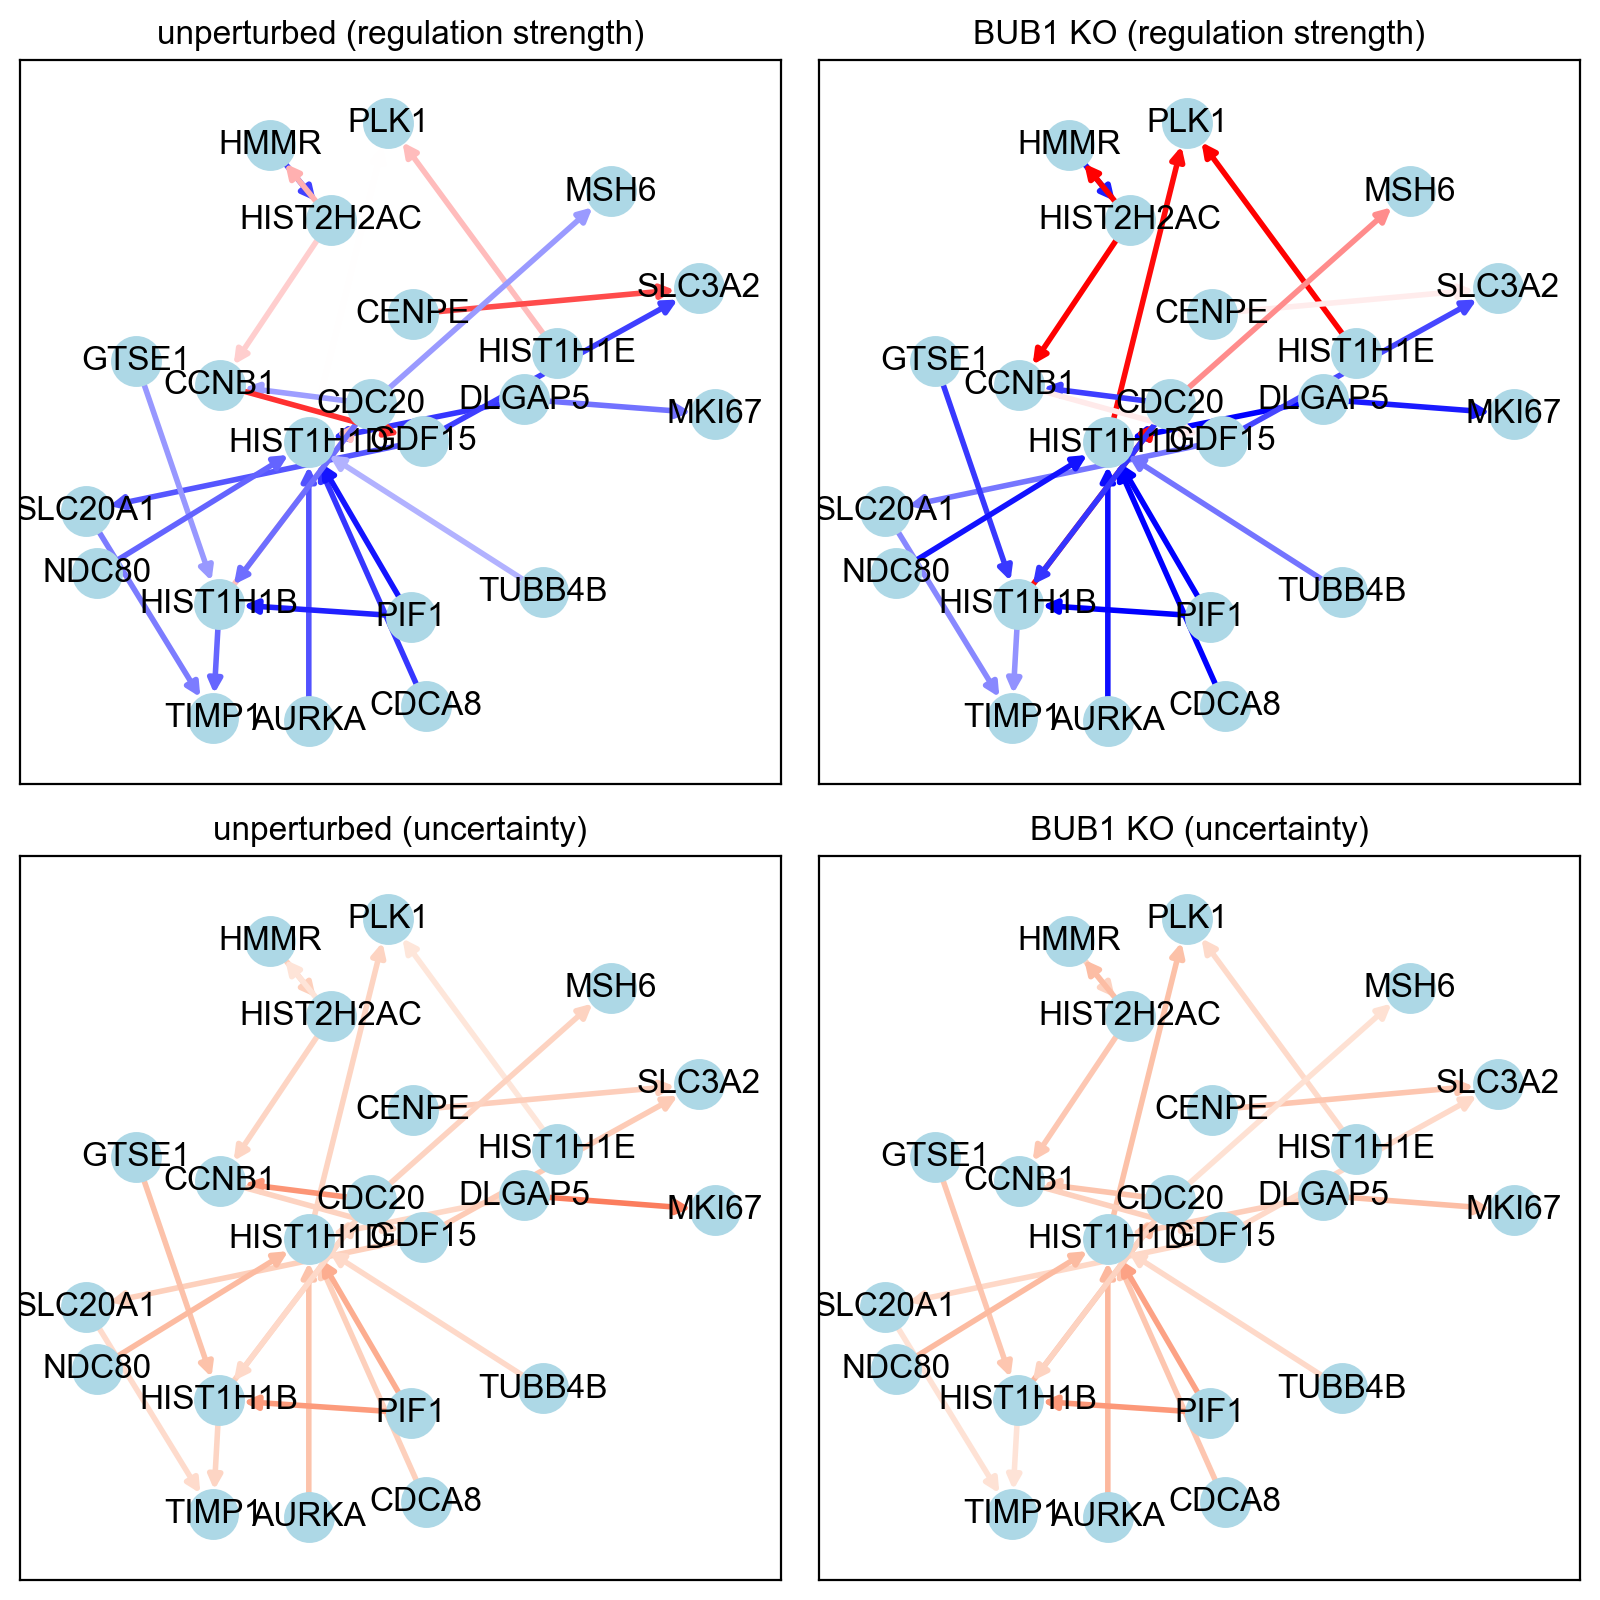

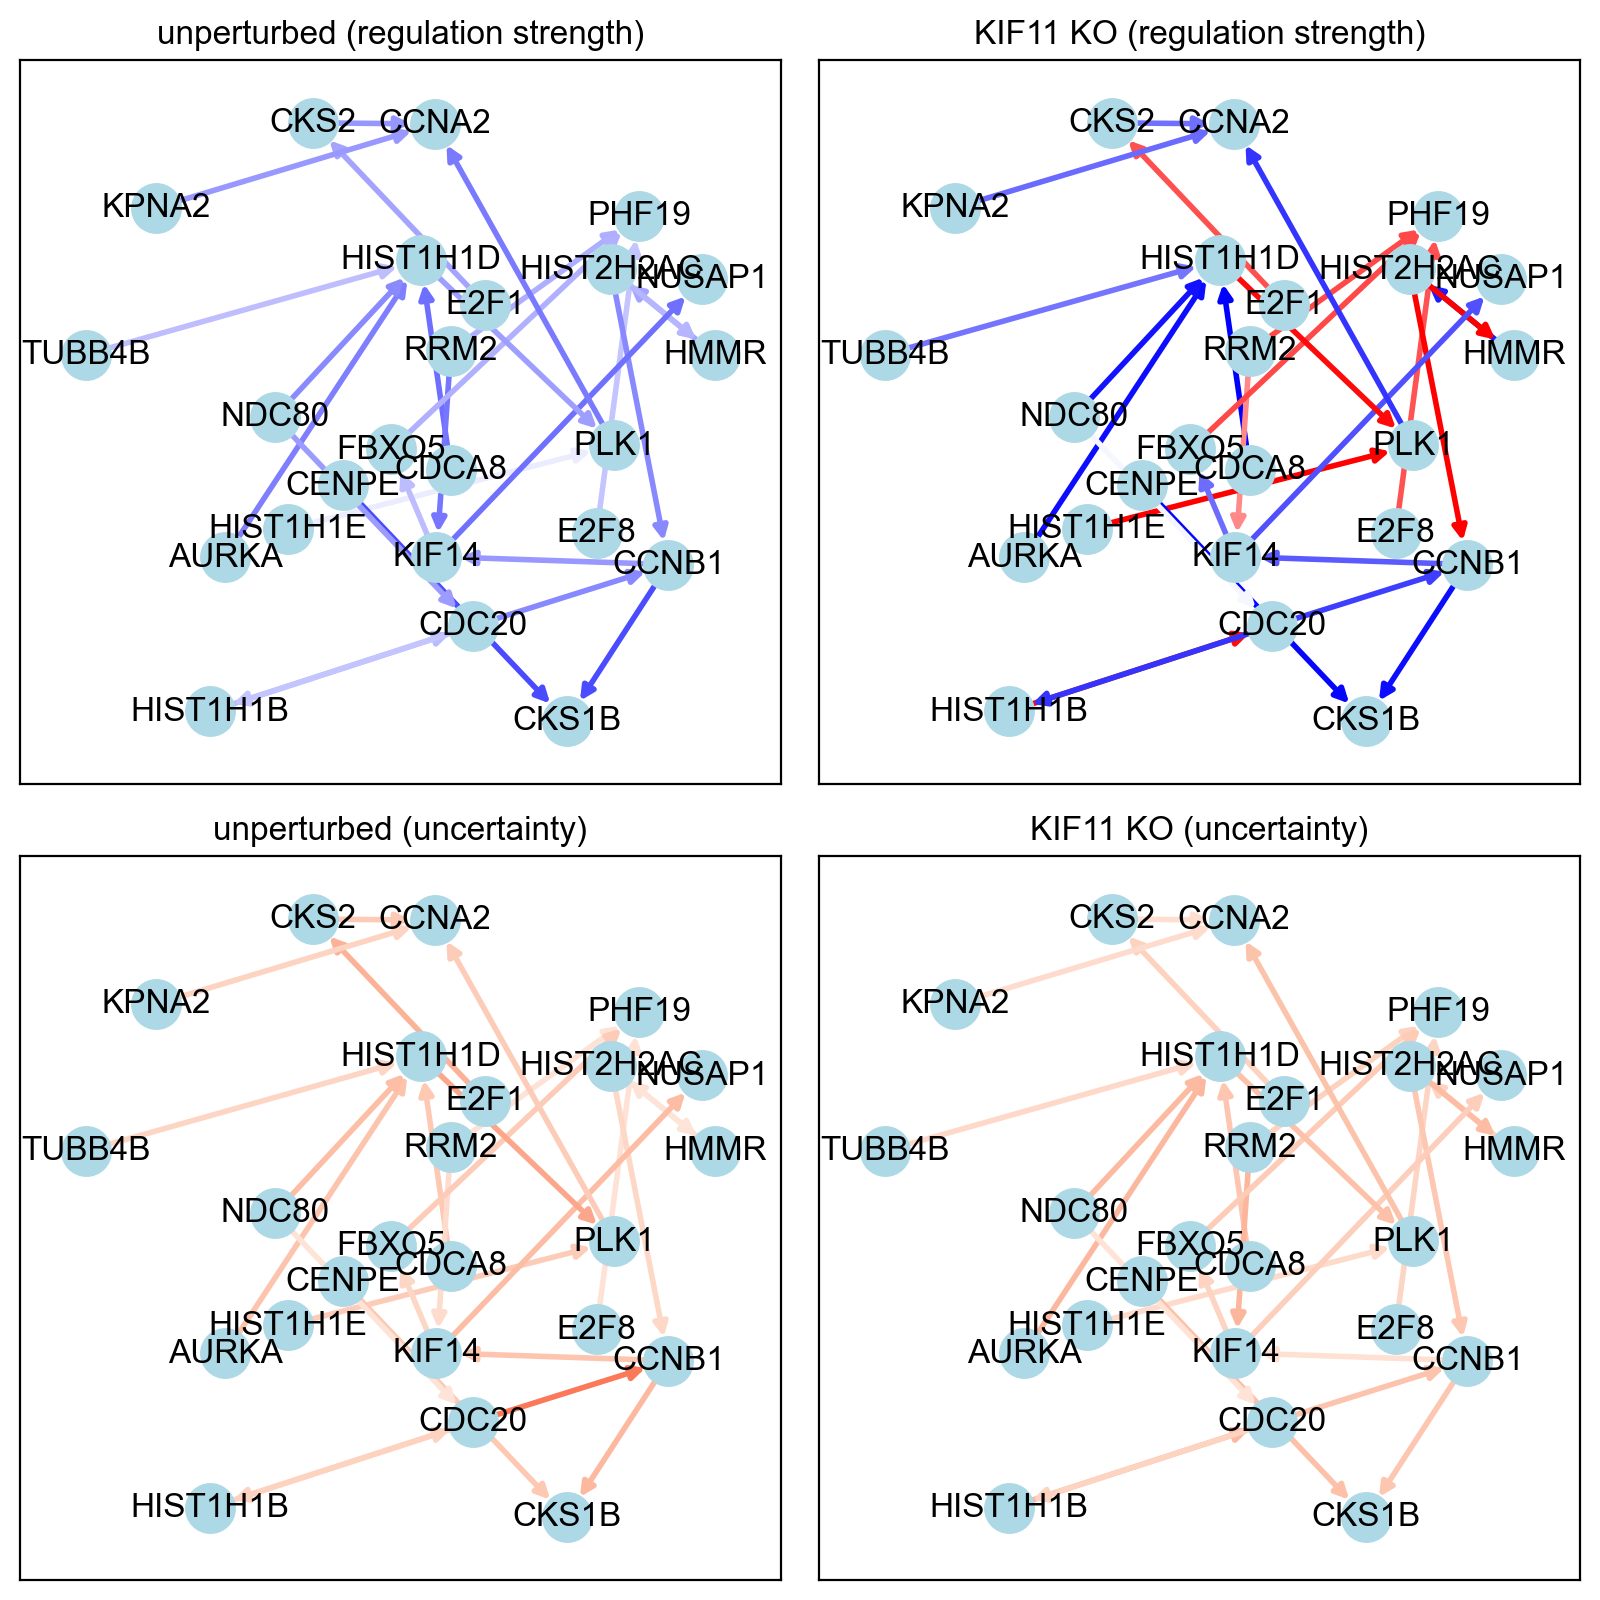

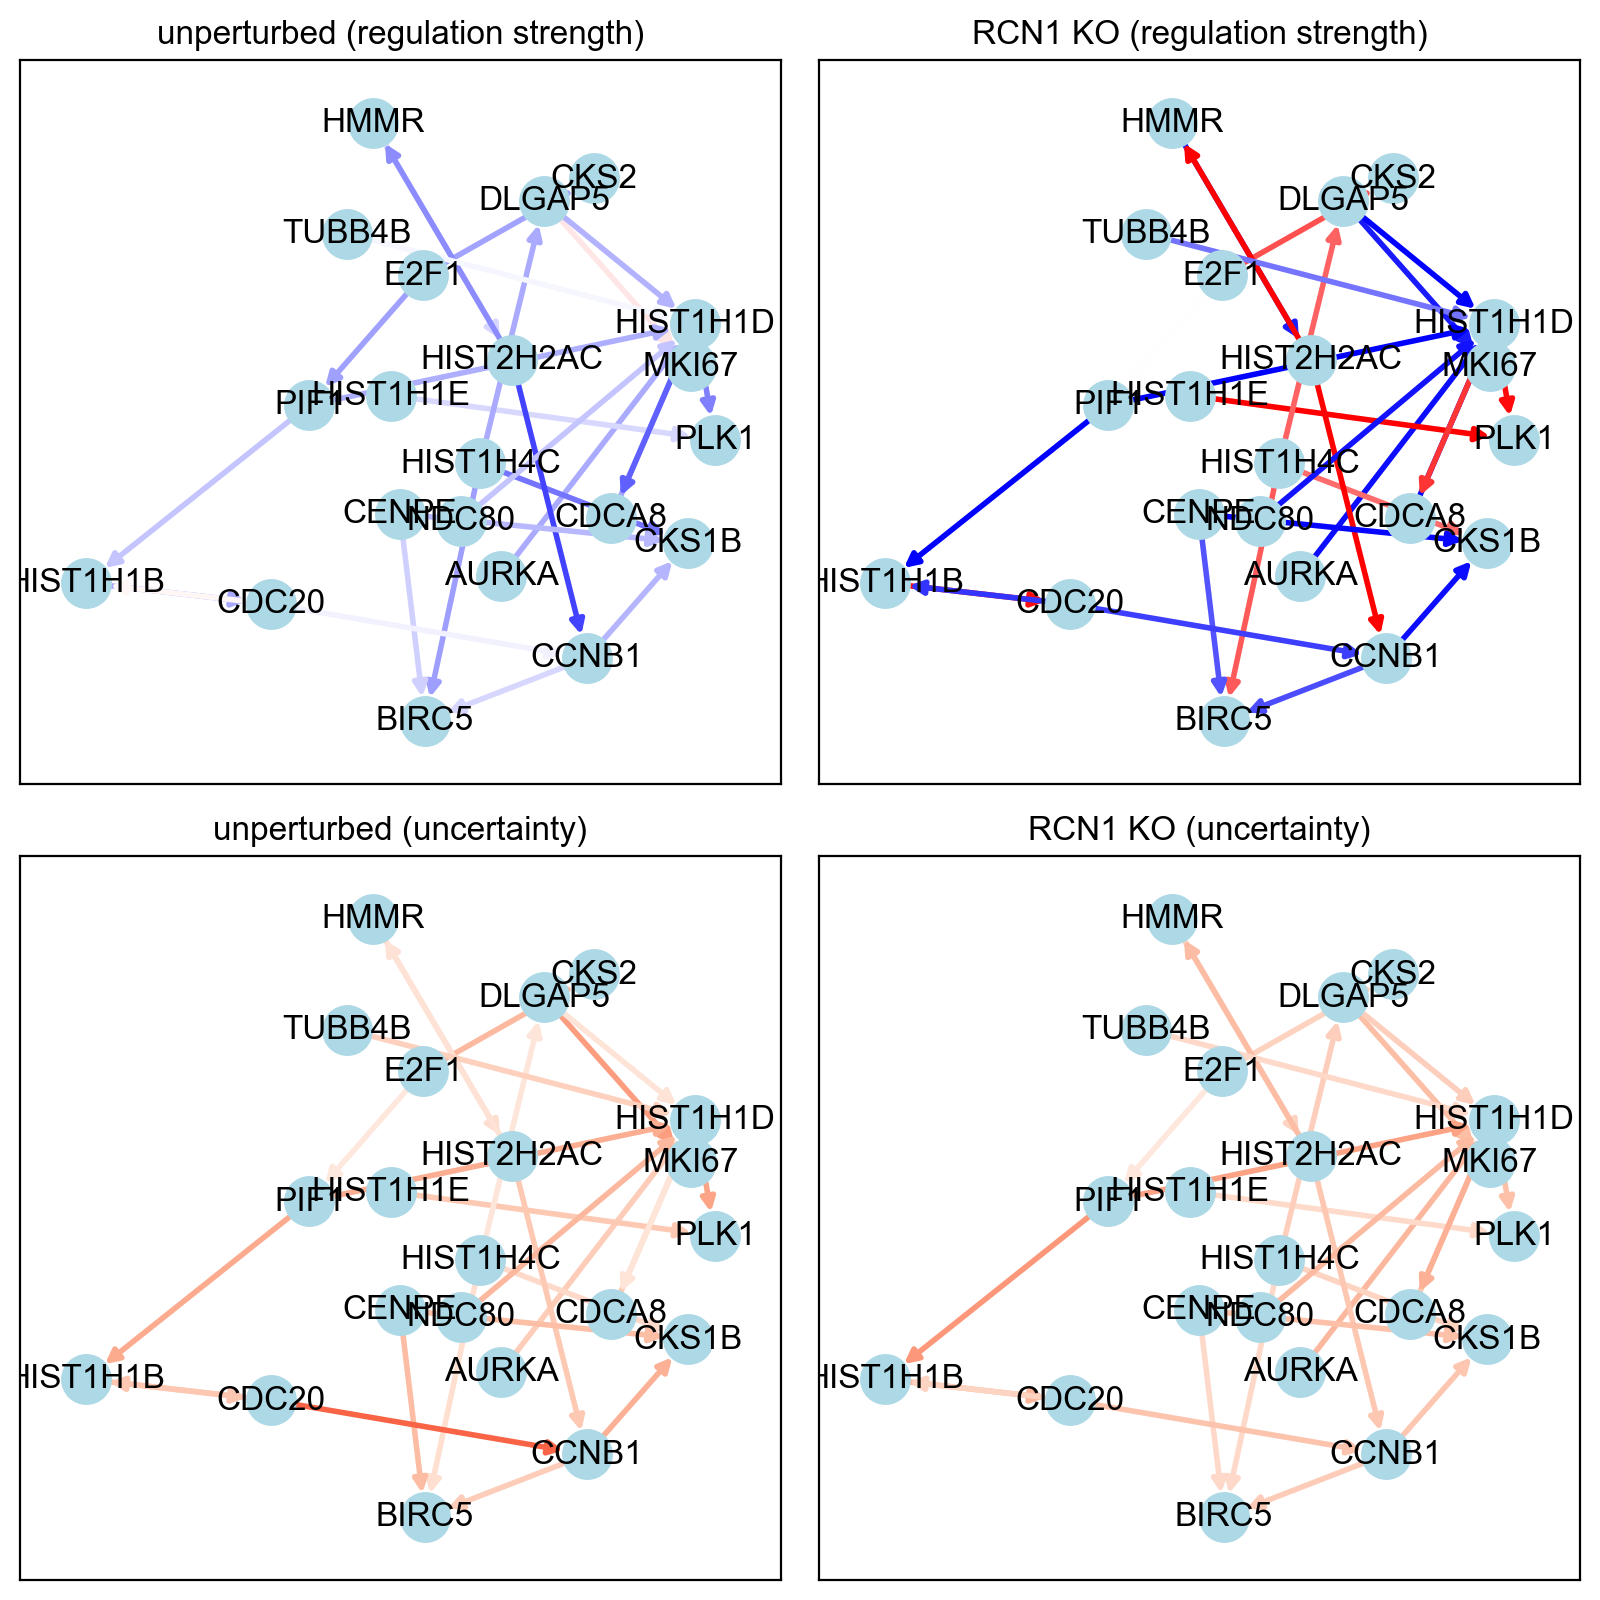

In [106]:
for ko in KO_genes:
    plot_most_affected_subgraph_for_ko(g, ko)

### DE genes

In [127]:
adata

AnnData object with n_obs × n_vars = 16835 × 4000
    obs: 'cell_barcode', 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'n_counts_all', 'S_score', 'G2M_score', 'phase', 'dpt_pseudotime', 'pseudotime_quantile', 'n_counts'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'gene_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'g1_s_ARGLU1_shortest_paths', 'g1_s_ASF1B_shortest_paths', 'g1_s_BUB1_shortest_paths', 'g1_s_CHPF_shortest_paths', 'g1_s_DNAJC3_shortest_paths', 'g1_s_HSPG2_shortest_paths', 'g1_s_KIF11_shortest_paths', 'g1_s_MLLT6_shortest_paths', 'g1_s_MSN_shortest_paths', 'g1_s_RCN1_shortest_paths', 'g1_s_STK38L_shortest_paths', 'g1_s_TBX1_shortest_paths', 'g1_s_obs_shortest_paths', 'g2_g1_ARGLU1_shortest_paths', 'g2_g1_ASF1B_shortest_paths', 'g2_g1_

In [128]:
sc.pp.log1p(adata)  # Ignore warning

In [129]:
sc.tl.rank_genes_groups(adata, 'gene', method='t-test', key_added = "t-test", reference="non-targeting")

In [130]:
ens_to_name_dict = {v: k for k, v in adata.var["gene_id"].to_dict().items()}
vf = np.vectorize(lambda x: ens_to_name_dict[x])

In [131]:
for ko in KO_genes:
    a = adata.uns["t-test"]['names'][ko]
    adata.uns["t-test"]['names'][ko] = vf(a)

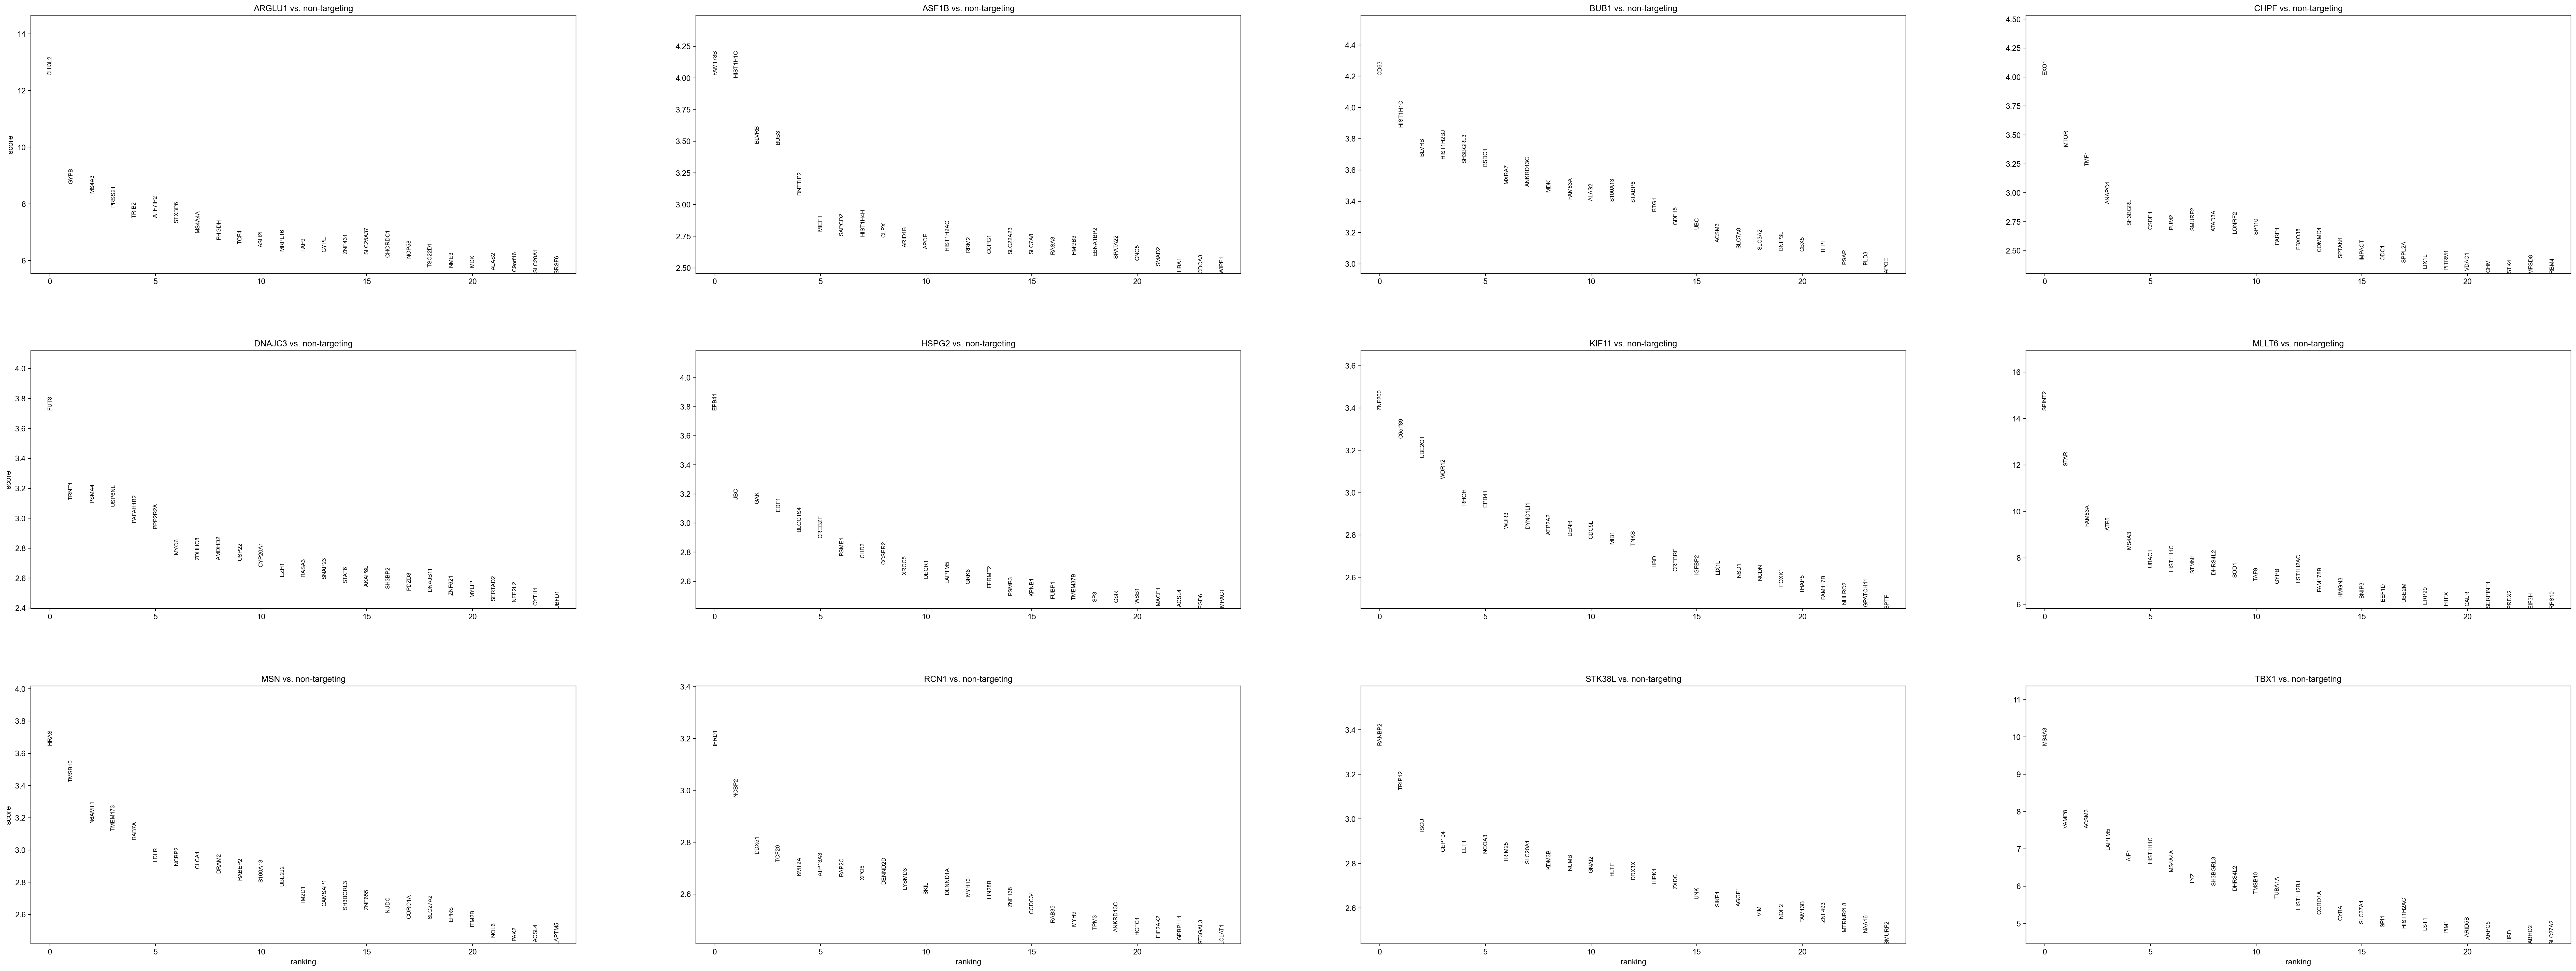

In [132]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test", )

In [133]:
for ko in KO_genes:
    abs_scores_ttests = {adata.uns["t-test"]['names'][ko][i]: np.abs(adata.uns["t-test"]['scores'][ko][i])
                       for i in range(len(adata.uns["t-test"]['names'][ko]))}

    # Sort dictionary according to value
    abs_scores_ttests = {k: v for k, v in sorted(abs_scores_ttests.items(), key=lambda item: -item[1])}

    # Most affected genes cebpa KO
    de_genes_ko = list(abs_scores_ttests)[:33]
    with open('DE_genes_' + ko + '_ko.txt', 'w') as f:
        for gene in de_genes_ko:
            f.write(f"{gene}\n")
